In [ ]:
MODELS = {
    'rc_metrics_NUSW': 'random_committee',
    'rf_dask_metrics_NUSW': 'random_forest',
    'xgb_dask_metrics_NUSW': 'xgboost',
}


In [32]:
MODELS = {
    'ddp_training_results_all': 'GNN Aggregated',
    'ddp_training_results_part': 'GNN Partitioned',
}


In [21]:
COL_TO_NAME = {
    'f1_malicious': 'F1 Score',
    'accuracy': 'Accuracy',
    'train_time': 'Training Time (s)',
    'SimulatedAnnealing': 'Simulated Annealing',
    'TabuSearch': 'Tabu Search',
    'SteepestDescent': 'Steepest Descent'
}

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_grid_updated(df, df_base, metric, x='selection_algorithm_name', y_min=None, y_max=None):
    """
    Plots a 3x3 grid with updated labels ('25%', '50%', '75%') and non-overlapping legend.
    """
    df_plot = df.copy()
    
    # 1. Map target_feature_k to relative ranks (0, 1, 2) per dataset
    def get_k_rank(series):
        unique_ks = sorted(series.unique())
        rank_map = {k: i for i, k in enumerate(unique_ks)}
        return series.map(rank_map)

    # Apply ranking on the Series directly
    df_plot['k_rank'] = df_plot.groupby('attack_cat', group_keys=False)['target_feature_k'].apply(get_k_rank)
    
    # Map ranks to percentages
    rank_labels = {0: '25%', 1: '50%', 2: '75%'}
    df_plot['Feature Count Level'] = df_plot['k_rank'].map(rank_labels)
    hue_order = ['25%', '50%', '75%']
    
    # 2. Setup Grid
    attack_cats = sorted(df_plot['attack_cat'].unique())
    if len(attack_cats) > 9: attack_cats = attack_cats[:9]
        
    fig, axes = plt.subplots(3, 3, figsize=(16, 16), sharey=True)
    axes = axes.flatten()
    
    # Use colorblind-friendly palette
    palette = sns.color_palette("tab10", n_colors=3)
    
    # 3. Plot Loop
    for i, cat in enumerate(attack_cats):
        ax = axes[i]
        subset = df_plot[df_plot['attack_cat'] == cat]
        
        sns.barplot(
            data=subset,
            x=x,
            y=metric,
            hue='Feature Count Level',
            hue_order=hue_order,
            palette=palette,
            errorbar='sd',
            ax=ax
        )
        
        # --- Add Baseline Line ---
        # Find the row in the baseline dataframe for this category
        base_row = df_base[df_base['attack_cat'] == cat]
        if not base_row.empty:
            base_val = base_row[metric].values[0]
            # Plot horizontal line
            ax.axhline(y=base_val, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
        
        # Simplified Title
        ax.set_title(cat, fontsize=14)
        ax.set_xlabel("")
        if i % 3 == 0:
            ax.set_ylabel(COL_TO_NAME[metric], fontsize=12)
        else:
            ax.set_ylabel("")
            
        # Remove local legend
        if ax.get_legend():
            ax.legend_.remove()
            
        ax.tick_params(axis='x', rotation=15)
        if y_min is not None or y_max is not None:
            ax.set_ylim((y_min, y_max))

    # 4. Global Legend & Layout
    # Extract handles/labels from the last axis
    handles, labels = ax.get_legend_handles_labels()
    
    # Add custom line handle
    line_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, label='All Features')
    handles.append(line_handle)
    labels.append('All Features')

    # Place legend outside to the right
    fig.legend(handles, labels, title='Feature Selection Ratio', loc='upper right', 
               bbox_to_anchor=(0.9, 1.0), fontsize=12, title_fontsize=14, ncol=2)

    fig.suptitle(f"{COL_TO_NAME[metric]} across all Attack Categories", fontsize=20, y=0.99)
    
    plt.tight_layout()
    # Adjust margins to accommodate title and legend
    plt.subplots_adjust(top=0.92, right=0.90) 
    
    return fig

In [8]:
df = pd.read_csv("./results/rc_metrics_NUSW.csv")
df_base = pd.read_csv("./results/all_rc_metrics_NUSW.csv")

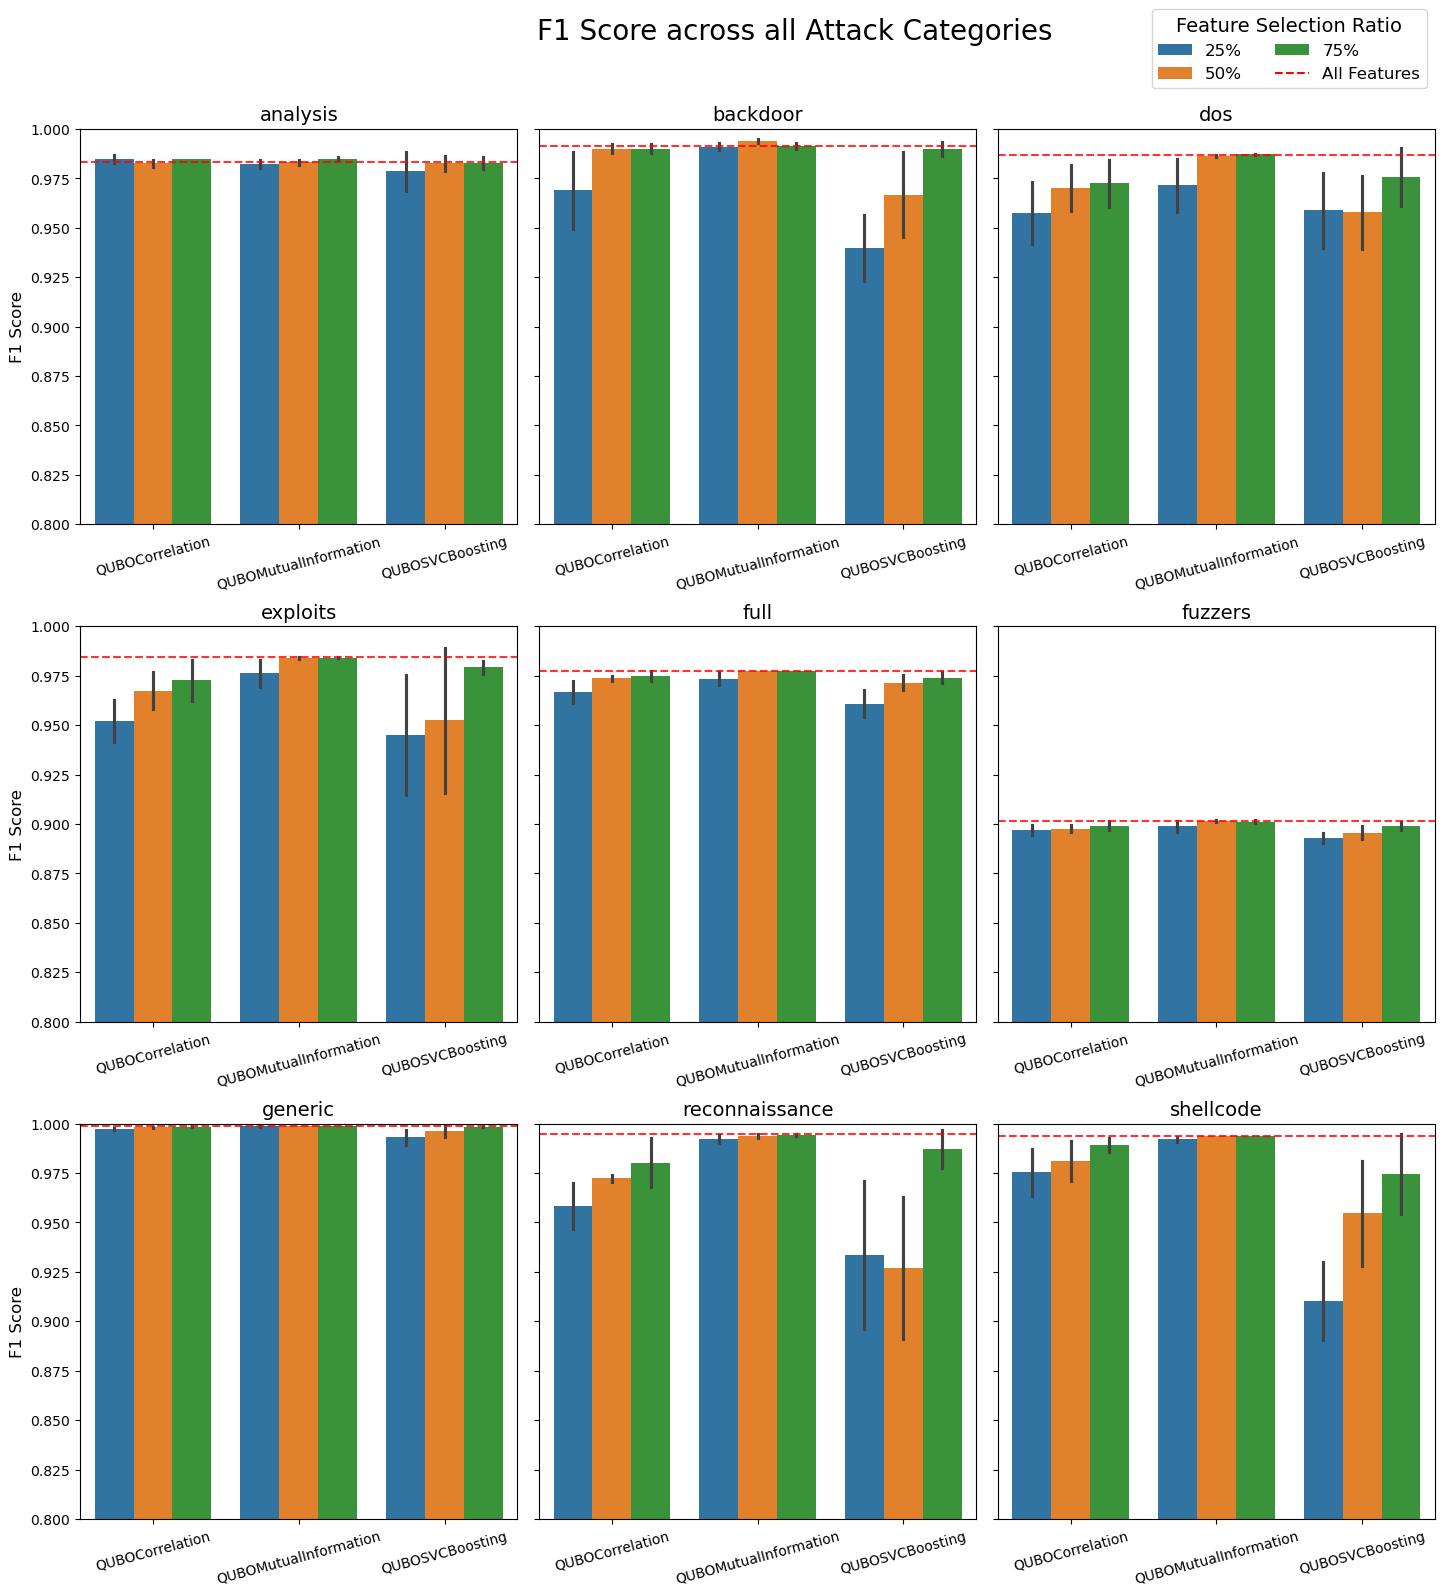

In [10]:
fig = plot_grid_updated(df, df_base, 'f1_malicious', y_min=0.8, y_max=1.0)
fig.savefig("./results/figures/barplot_f1_rc_NUSW.png", dpi=300)

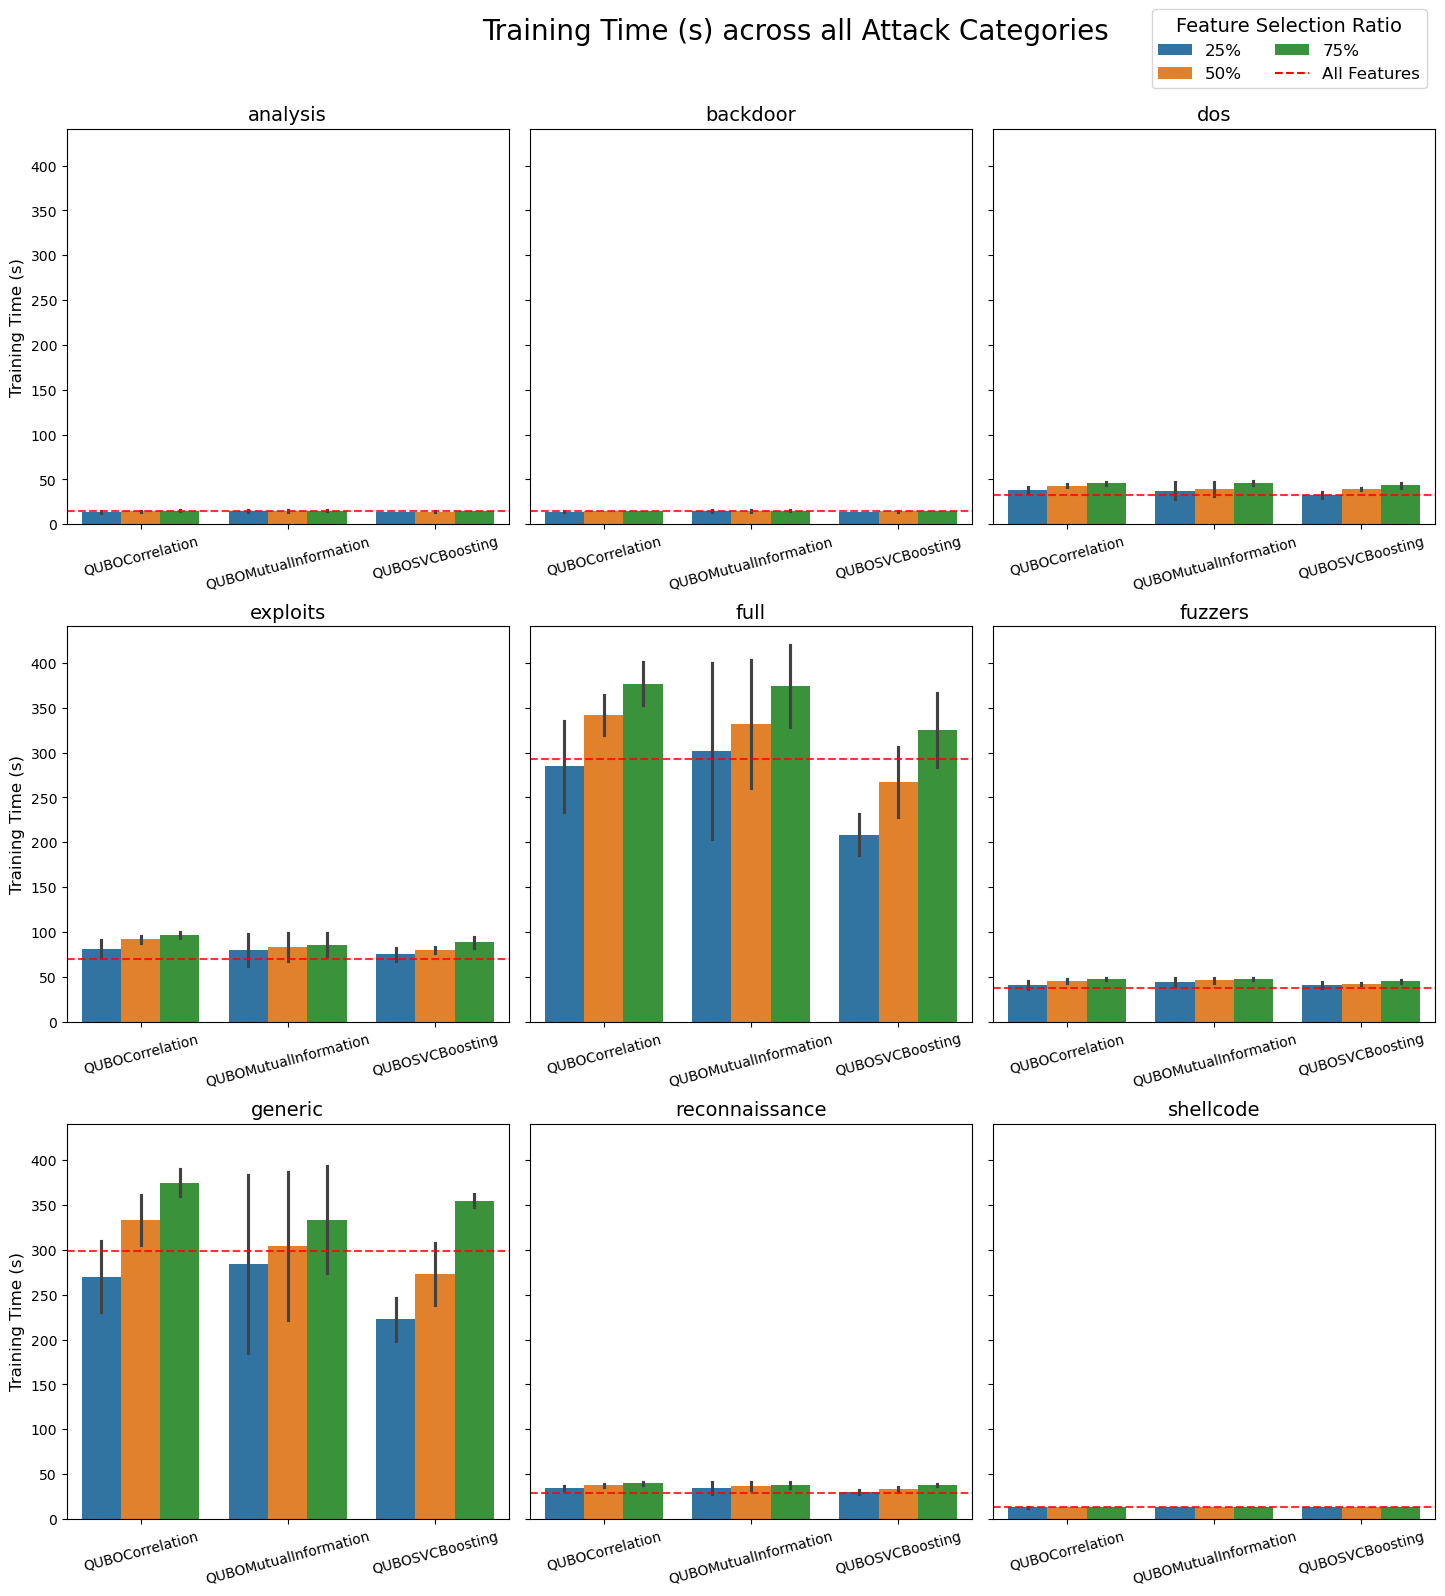

In [11]:
fig = plot_grid_updated(df, df_base, 'train_time', y_min=None, y_max=None)

In [23]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

def plot_speedup_barplot_all(df_main, df_base):
    """
    Plots a single Barplot showing the aggregated Speedup (All/QFS) 
    for all datasets side-by-side.
    """
    # 1. Prepare Data
    base_subset = df_base[['attack_cat', 'train_time']].rename(columns={'train_time': 'baseline_train_time'})
    df_merged = pd.merge(df_main, base_subset, on='attack_cat', how='left')
    
    # Calculate Metric
    df_merged['speedup'] = df_merged['baseline_train_time'] / df_merged['train_time']
    
    # 2. Map Ranks
    def get_k_rank(series):
        unique_ks = sorted(series.unique())
        rank_map = {k: i for i, k in enumerate(unique_ks)}
        return series.map(rank_map)

    df_merged['k_rank'] = df_merged.groupby('attack_cat', group_keys=False)['target_feature_k'].apply(get_k_rank)
    rank_labels = {0: '25%', 1: '50%', 2: '75%'}
    df_merged['Feature Count Level'] = df_merged['k_rank'].map(rank_labels)
    hue_order = ['25%', '50%', '75%']
    
    # Sort
    df_merged = df_merged.sort_values('attack_cat')

    # 3. Plot
    plt.figure(figsize=(20, 8))
    palette = sns.color_palette("tab10", n_colors=3)
    
    sns.barplot(
        data=df_merged,
        x='attack_cat',
        y='speedup',
        hue='Feature Count Level',
        hue_order=hue_order,
        palette=palette,
        errorbar='sd'
    )
    
    # Baseline Line
    plt.axhline(1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
    
    # Formatting
    plt.title("Aggregated Training Speedup (All / QFS) across All Datasets", fontsize=20)
    plt.xlabel("Dataset", fontsize=14)
    plt.ylabel("Speedup (All / QFS)", fontsize=14)
    plt.xticks(rotation=15, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Manual Legend
    handles = [mpatches.Patch(color=palette[i], label=label) for i, label in enumerate(hue_order)]
    line_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, label='All Features')
    handles.append(line_handle)
    
    plt.legend(handles=handles, title='Feature Selection Ratio', loc='upper right', fontsize=12, title_fontsize=14)

    # Save
    output_filename = "single_barplot_speedup_all.png"
    plt.savefig(output_filename, bbox_inches='tight')
    return output_filename

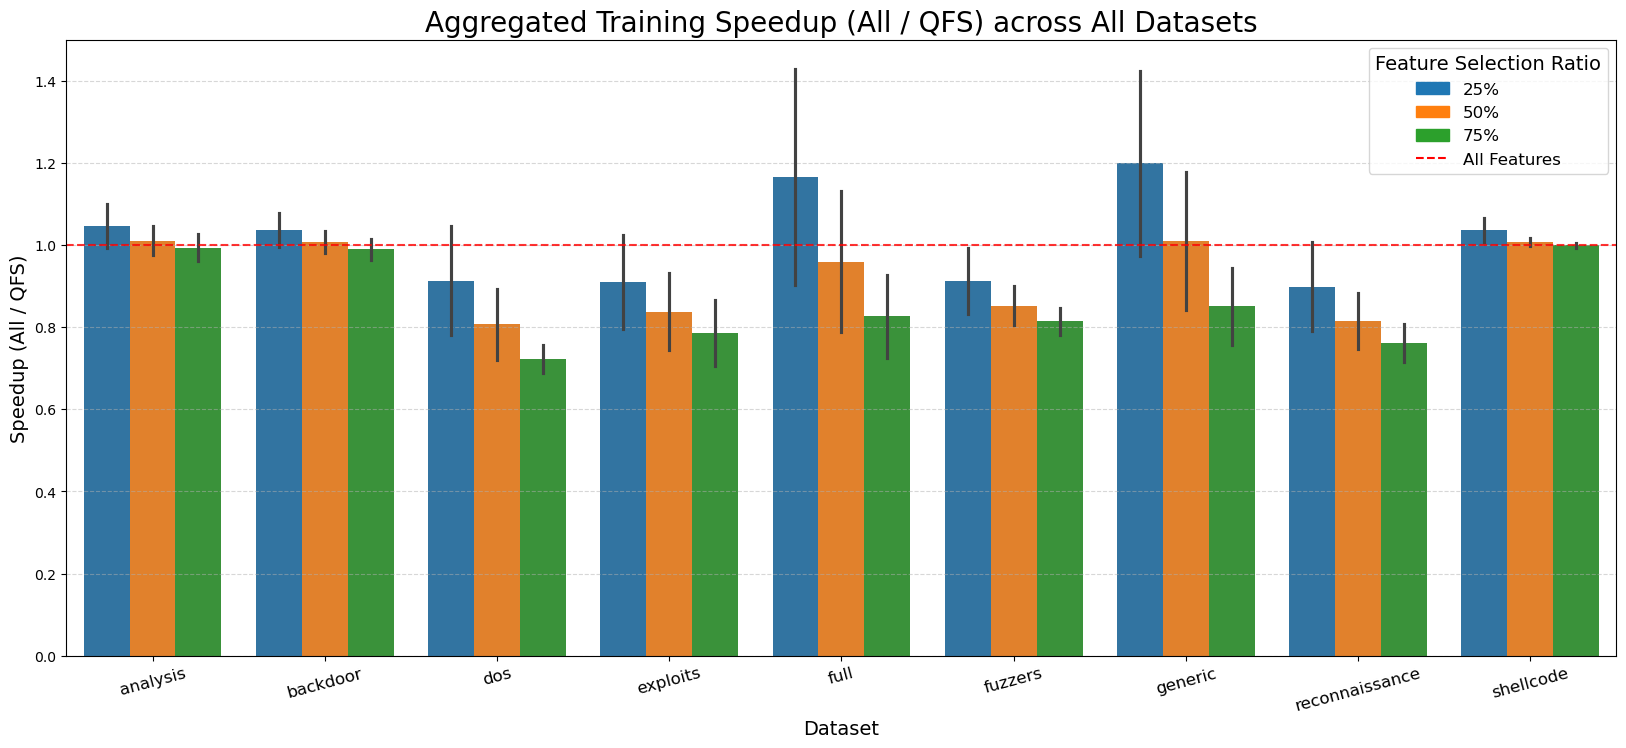

In [13]:
fig = plot_speedup_barplot_all(df, df_base)

In [24]:
qfs_df = pd.read_csv("./data/QFS_features.csv")

In [25]:
def plot_fit_time_grid(df):    
    # 1. Bin Feature Counts into Levels (25%, 50%, 75%)
    def get_k_level(series):
        unique_vals = sorted(series.unique())
        if len(unique_vals) == 1:
            return pd.Series(['25%'] * len(series), index=series.index)
        elif len(unique_vals) == 2:
            return series.map({unique_vals[0]: '25%', unique_vals[1]: '75%'})
        elif len(unique_vals) == 3:
            return series.map({unique_vals[0]: '25%', unique_vals[1]: '50%', unique_vals[2]: '75%'})
        else:
            # Use qcut for continuous-like ranges
            return pd.qcut(series, 3, labels=['25%', '50%', '75%'])

    df['Feature Count Level'] = df.groupby('category', group_keys=False)['target_feature_k'].apply(get_k_level)
    hue_order = ['25%', '50%', '75%']
    
    # 2. Setup Grid
    attack_cats = sorted(df['category'].unique())
    if len(attack_cats) > 9: attack_cats = attack_cats[:9]
        
    # sharey=False because fit times vary significantly by dataset size
    fig, axes = plt.subplots(3, 3, figsize=(16, 16), sharey=False)
    axes = axes.flatten()
    palette = sns.color_palette("tab10", n_colors=3)
    
    # 3. Plot Loop
    for i, cat in enumerate(attack_cats):
        ax = axes[i]
        subset = df[df['category'] == cat]
        
        sns.barplot(
            data=subset,
            x='selection_algorithm_name',
            y='selection_algorithm_fit_time',
            hue='Feature Count Level',
            hue_order=hue_order,
            palette=palette,
            errorbar='sd', # Aggregate over QUBO_solver
            ax=ax
        )
        
        ax.set_title(cat, fontsize=14)
        ax.set_xlabel("")
        ax.set_ylabel("Fit Time (s)", fontsize=12)
        
        if ax.get_legend():
            ax.legend_.remove()
            
        ax.tick_params(axis='x', rotation=15)

    # 4. Global Legend
    handles = [mpatches.Patch(color=palette[i], label=label) for i, label in enumerate(hue_order)]
    fig.legend(handles=handles, labels=hue_order, title='Feature Selection Ratio', 
               loc='upper center', bbox_to_anchor=(0.5, 0.965), fontsize=12, title_fontsize=14, ncol=4)

    fig.suptitle("Selection Algorithm Fit Time", fontsize=20, y=0.99)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, right=0.90) 
    
    return fig

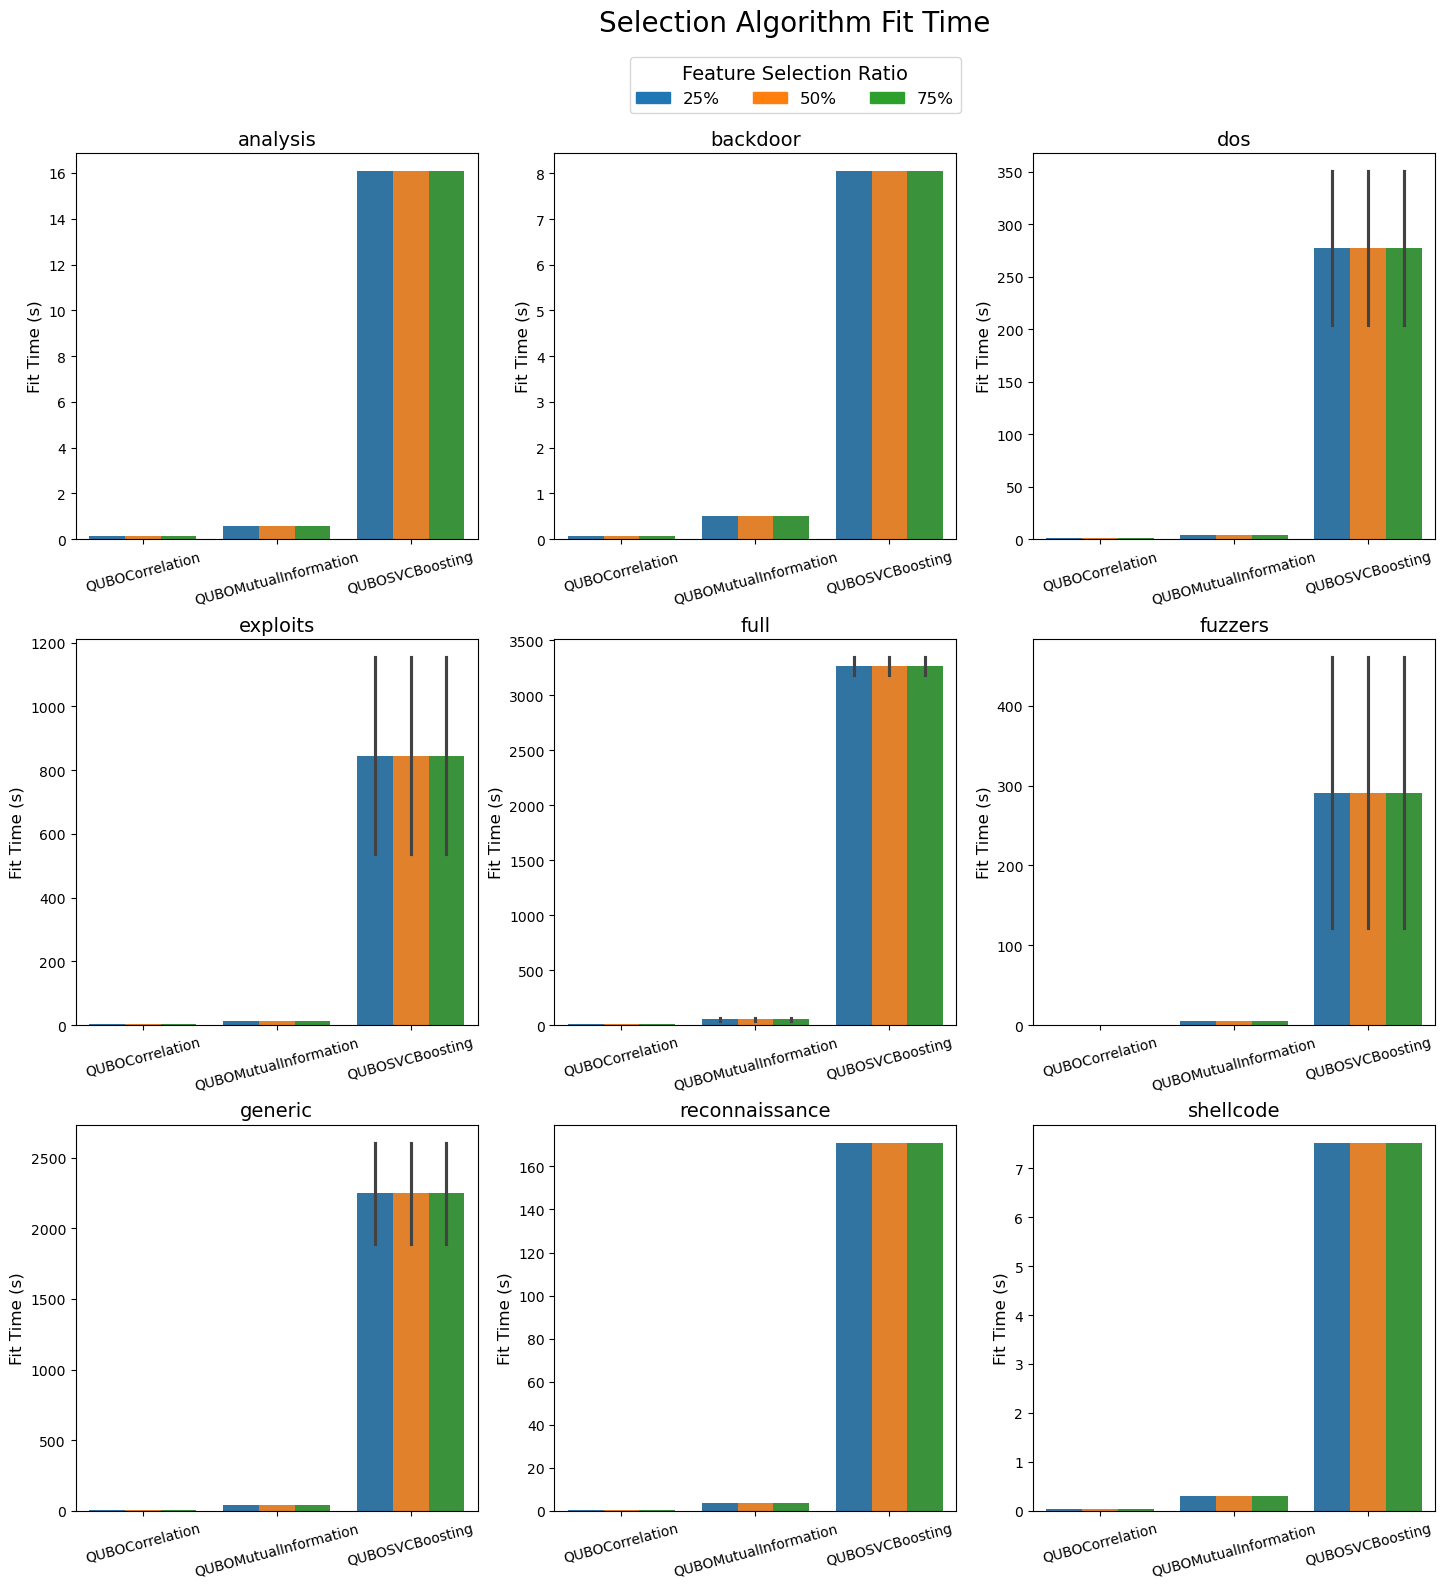

In [ ]:
fig = plot_fit_time_grid(qfs_df)
fig.savefig("./results/figures/fit_time_qfs.png", dpi=300)

In [26]:
def plot_select_time_grid(df):    
    # 1. Bin Feature Counts into Levels (25%, 50%, 75%)
    def get_k_level(series):
        unique_vals = sorted(series.unique())
        if len(unique_vals) == 1:
            return pd.Series(['25%'] * len(series), index=series.index)
        elif len(unique_vals) == 2:
            return series.map({unique_vals[0]: '25%', unique_vals[1]: '75%'})
        elif len(unique_vals) == 3:
            return series.map({unique_vals[0]: '25%', unique_vals[1]: '50%', unique_vals[2]: '75%'})
        else:
            # Use qcut for continuous-like ranges
            return pd.qcut(series, 3, labels=['25%', '50%', '75%'])

    df['Feature Count Level'] = df.groupby('category', group_keys=False)['target_feature_k'].apply(get_k_level)
    hue_order = ['25%', '50%', '75%']
    
    # 2. Setup Grid
    attack_cats = sorted(df['category'].unique())
    if len(attack_cats) > 9: attack_cats = attack_cats[:9]
        
    # sharey=False because fit times vary significantly by dataset size
    fig, axes = plt.subplots(3, 3, figsize=(16, 16), sharey=False)
    axes = axes.flatten()
    palette = sns.color_palette("tab10", n_colors=3)
    
    # 3. Plot Loop
    for i, cat in enumerate(attack_cats):
        ax = axes[i]
        subset = df[df['category'] == cat]
        
        sns.barplot(
            data=subset,
            x='QUBO_solver',
            y='selection_algorithm_select_best_k_time',
            hue='Feature Count Level',
            hue_order=hue_order,
            palette=palette,
            errorbar='sd', # Aggregate over QUBO_solver
            ax=ax
        )
        
        ax.set_title(cat, fontsize=14)
        ax.set_xlabel("")
        ax.set_ylabel("Selection Time (s)", fontsize=12)
        
        if ax.get_legend():
            ax.legend_.remove()
            
        ax.tick_params(axis='x', rotation=15)

    # 4. Global Legend
    handles = [mpatches.Patch(color=palette[i], label=label) for i, label in enumerate(hue_order)]
    fig.legend(handles=handles, labels=hue_order, title='Feature Selection Ratio', 
               loc='upper center', bbox_to_anchor=(0.5, 0.965), fontsize=12, title_fontsize=14, ncol=4)

    fig.suptitle("QUBO Solver Selection Time", fontsize=20, y=0.99)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, right=0.90) 
    
    return fig

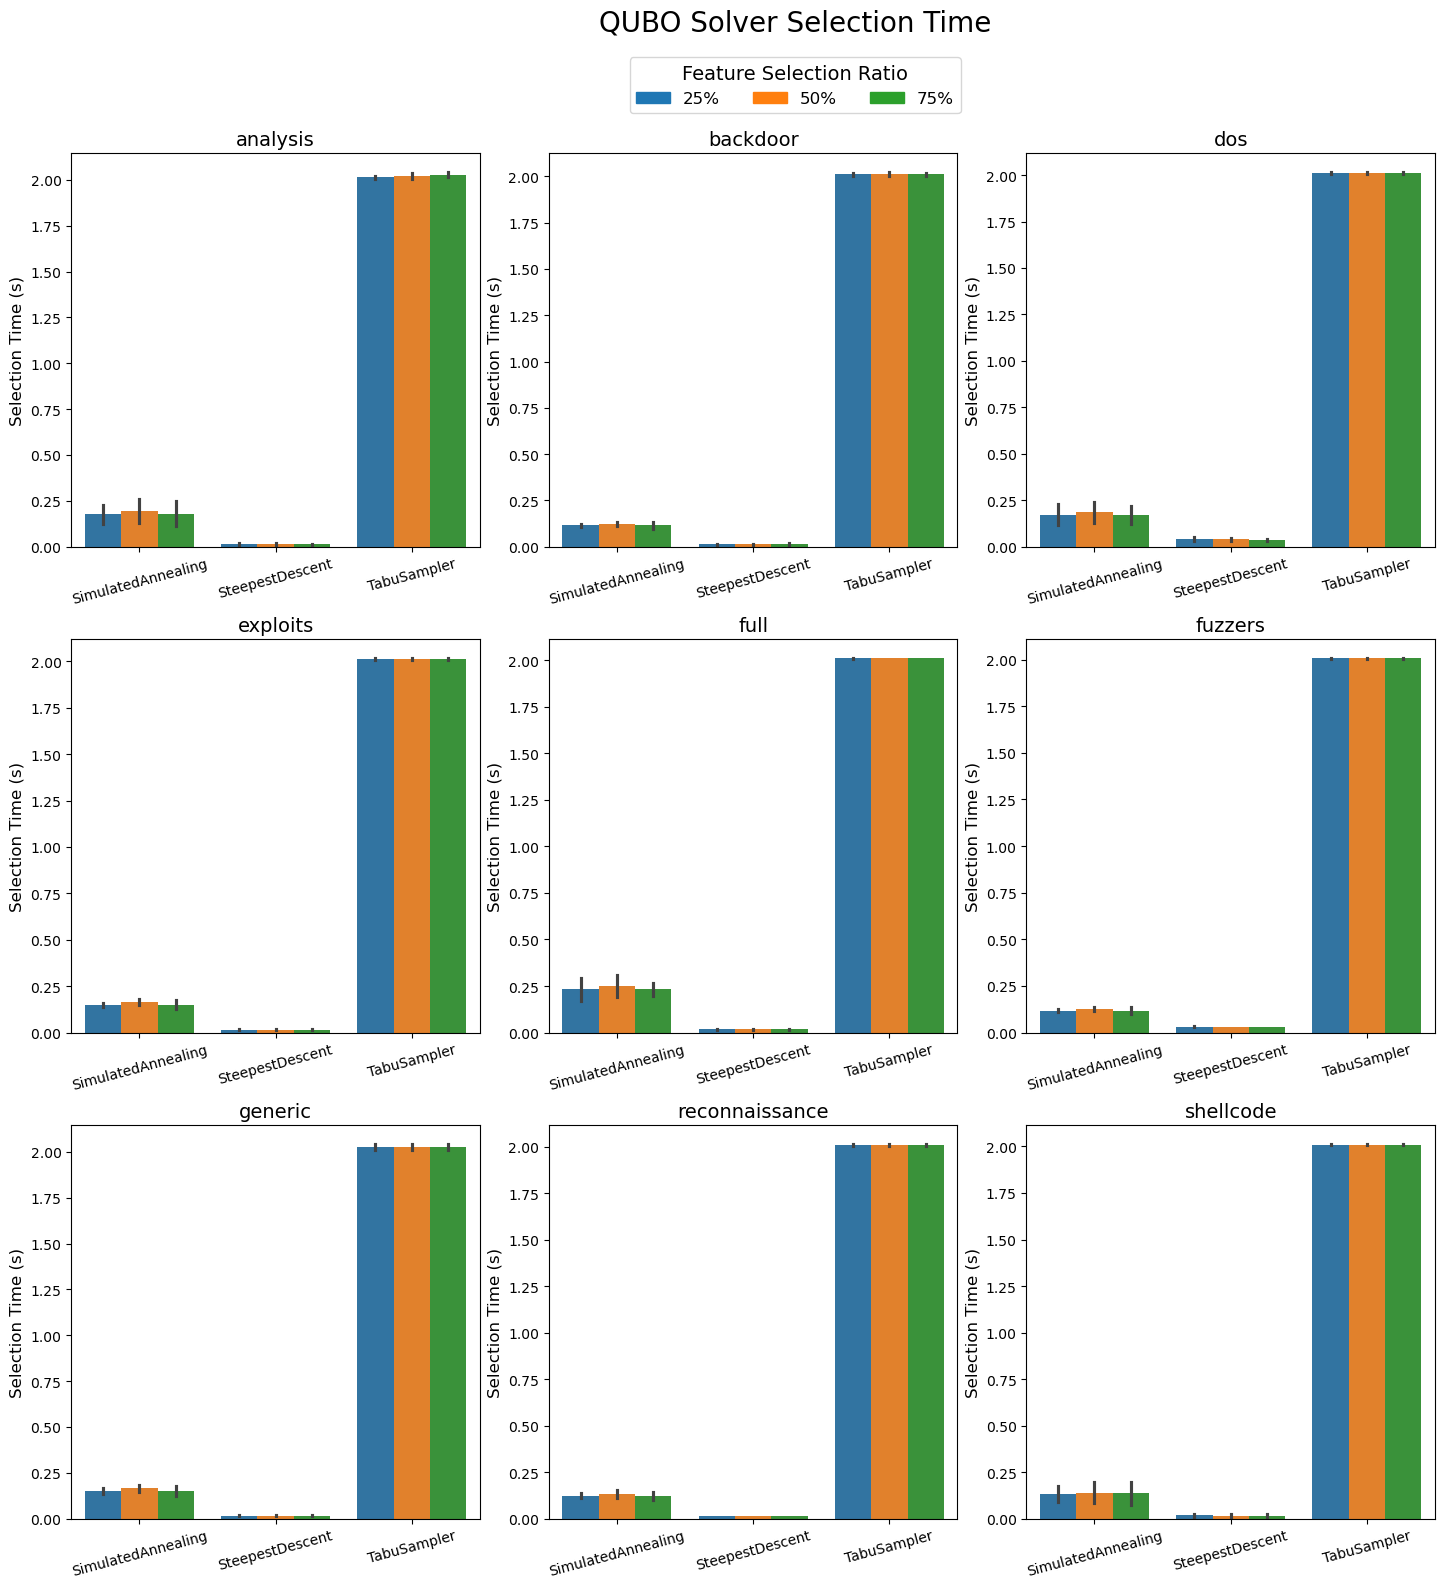

In [ ]:
fig = plot_select_time_grid(qfs_df)
fig.savefig("./results/figures/select_time_qfs.png", dpi=300)

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_train_time_with_baseline_bar(df_main, df_base):
    """
    Plots a single Barplot showing aggregated train_time for all datasets,
    including a bar for 'All Features' in each group.
    """
    # 1. Process Main Data
    df_plot = df_main.copy()
    
    # Map Feature Ranks
    def get_k_rank(series):
        unique_ks = sorted(series.unique())
        rank_map = {k: i for i, k in enumerate(unique_ks)}
        return series.map(rank_map)

    df_plot['k_rank'] = df_plot.groupby('attack_cat', group_keys=False)['target_feature_k'].apply(get_k_rank)
    rank_labels = {0: '25%', 1: '50%', 2: '75%'}
    df_plot['Feature Count Level'] = df_plot['k_rank'].map(rank_labels)
    
    # Subset
    df_plot_subset = df_plot[['attack_cat', 'train_time', 'Feature Count Level']].copy()

    # 2. Process Baseline Data
    df_base_subset = df_base[['attack_cat', 'train_time']].copy()
    df_base_subset['Feature Count Level'] = 'All Features'
    
    # 3. Combine
    df_combined = pd.concat([df_plot_subset, df_base_subset], ignore_index=True)
    df_combined = df_combined.sort_values('attack_cat')

    # 4. Define Palette
    tab10 = sns.color_palette("tab10", n_colors=10)
    palette = {
        '25%': tab10[0],
        '50%': tab10[1],
        '75%': tab10[2],
        'All Features': tab10[3] # Red
    }
    hue_order = ['25%', '50%', '75%', 'All Features']

    # 5. Plot
    fig = plt.figure(figsize=(20, 8))
    
    sns.barplot(
        data=df_combined,
        x='attack_cat',
        y='train_time',
        hue='Feature Count Level',
        hue_order=hue_order,
        palette=palette,
        errorbar='sd'
    )
    
    # Formatting
    plt.title("Average Training Time across All Datasets", fontsize=20)
    plt.xlabel("Dataset", fontsize=14)
    plt.ylabel("Training Time (s)", fontsize=14)
    plt.xticks(rotation=15, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Legend
    handles = [mpatches.Patch(color=palette[label], label=label) for label in hue_order]
    plt.legend(handles=handles, title='Feature Selection Ratio', loc='upper right', fontsize=12, title_fontsize=14)

    # output_filename = "single_barplot_train_time_with_baseline_bar.png"
    # plt.savefig(output_filename, bbox_inches='tight')
    return fig

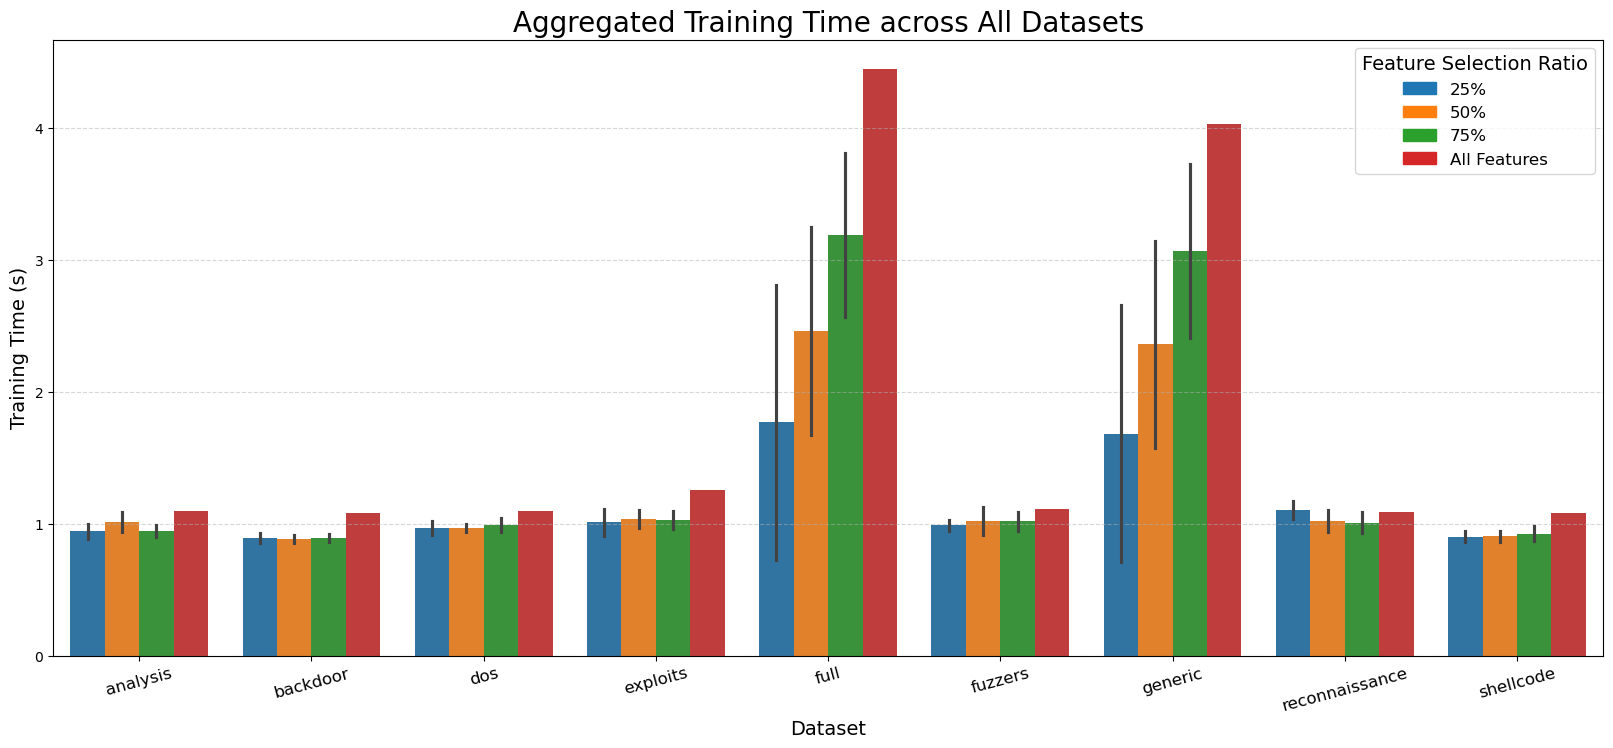

In [108]:
fig = plot_train_time_with_baseline_bar(df, df_base)

In [28]:
def plot_total_time_grid(df_main, df_qfs, df_base, qubo_solver='SimulatedAnnealing'):
    # 1. Prepare QFS Data
    df_qfs_clean = df_qfs.rename(columns={'category': 'attack_cat'})
    
    # 2. Merge Main (Metrics) and QFS Data
    # Inner join on key columns to match specific experiments
    df_merged = pd.merge(
        df_main, 
        df_qfs_clean[['attack_cat', 'selection_algorithm_name', 'target_feature_k', 'QUBO_solver', 
                      'selection_algorithm_fit_time', 'selection_algorithm_select_best_k_time']],
        on=['attack_cat', 'selection_algorithm_name', 'target_feature_k', 'QUBO_solver'],
        how='inner'
    )
    
    # 3. Calculate Total Time
    df_merged['total_time'] = (
        df_merged['train_time'] + 
        df_merged['selection_algorithm_fit_time'] + 
        df_merged['selection_algorithm_select_best_k_time']
    )
    
    df_merged = df_merged[df_merged['QUBO_solver'] == qubo_solver]
    
    # 4. Map Feature Count Levels
    def get_k_rank(series):
        unique_ks = sorted(series.unique())
        rank_map = {k: i for i, k in enumerate(unique_ks)}
        return series.map(rank_map)

    df_merged['k_rank'] = df_merged.groupby('attack_cat', group_keys=False)['target_feature_k'].apply(get_k_rank)
    rank_labels = {0: '25%', 1: '50%', 2: '75%'}
    df_merged['Feature Count Level'] = df_merged['k_rank'].map(rank_labels)
    hue_order = ['25%', '50%', '75%']
    
    # 5. Setup Grid
    attack_cats = sorted(df_merged['attack_cat'].unique())
    if len(attack_cats) > 9: attack_cats = attack_cats[:9]
        
    fig, axes = plt.subplots(3, 3, figsize=(16, 16), sharey=False)
    axes = axes.flatten()
    palette = sns.color_palette("tab10", n_colors=3)
    
    # 6. Plot Loop
    for i, cat in enumerate(attack_cats):
        ax = axes[i]
        subset = df_merged[df_merged['attack_cat'] == cat]
        
        sns.barplot(
            data=subset,
            x='selection_algorithm_name',
            y='total_time',
            hue='Feature Count Level',
            hue_order=hue_order,
            palette=palette,
            errorbar='sd',
            ax=ax
        )
        
        # Add Baseline (Train Time Only)
        base_row = df_base[df_base['attack_cat'] == cat]
        if not base_row.empty:
            base_val = base_row['train_time'].values[0]
            ax.axhline(y=base_val, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
        
        ax.set_title(cat, fontsize=14)
        ax.set_xlabel("")
        ax.set_ylabel("Total Time (Fit+Select+Train) [s]", fontsize=10)
        
        if ax.get_legend():
            ax.legend_.remove()
        ax.tick_params(axis='x', rotation=15)

    # 7. Global Legend
    handles = [mpatches.Patch(color=palette[i], label=label) for i, label in enumerate(hue_order)]
    line_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, label='Baseline')
    handles.append(line_handle)
    labels = hue_order + ['Baseline']
    
    fig.legend(handles=handles, labels=labels, title='Feature Selection Ratio', 
               loc='upper center', bbox_to_anchor=(0.5, 0.965), fontsize=12, title_fontsize=14, ncol=4)

    fig.suptitle(f"Total Time for {COL_TO_NAME[qubo_solver]} (Fit + Select + Train) vs Baseline", fontsize=20, y=0.99)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, right=0.90) 
    
    return fig

# Usage
# plot_total_time_grid(df_logreg, df_qfs, df_base)

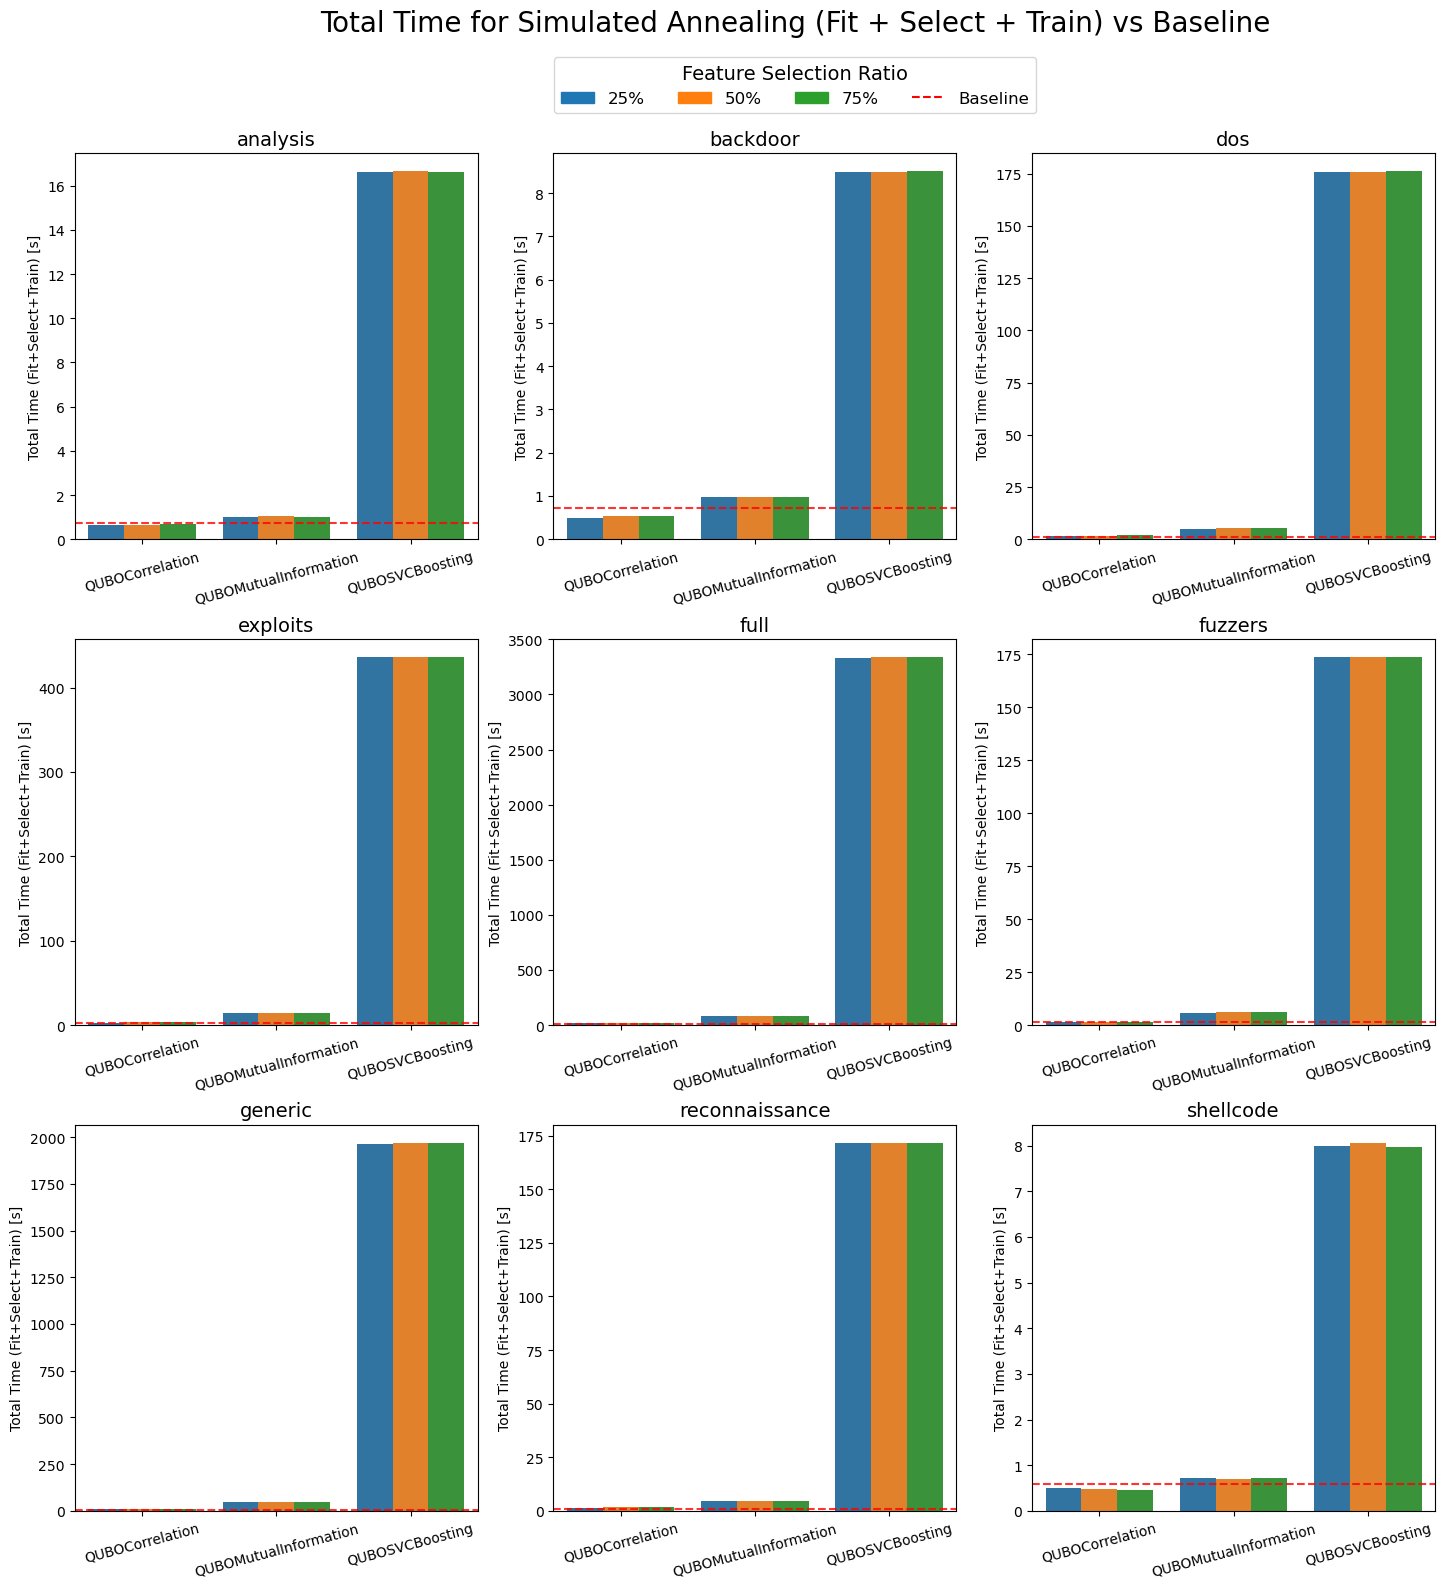

In [111]:
fig = plot_total_time_grid(df, qfs_df, df_base, qubo_solver='SimulatedAnnealing')

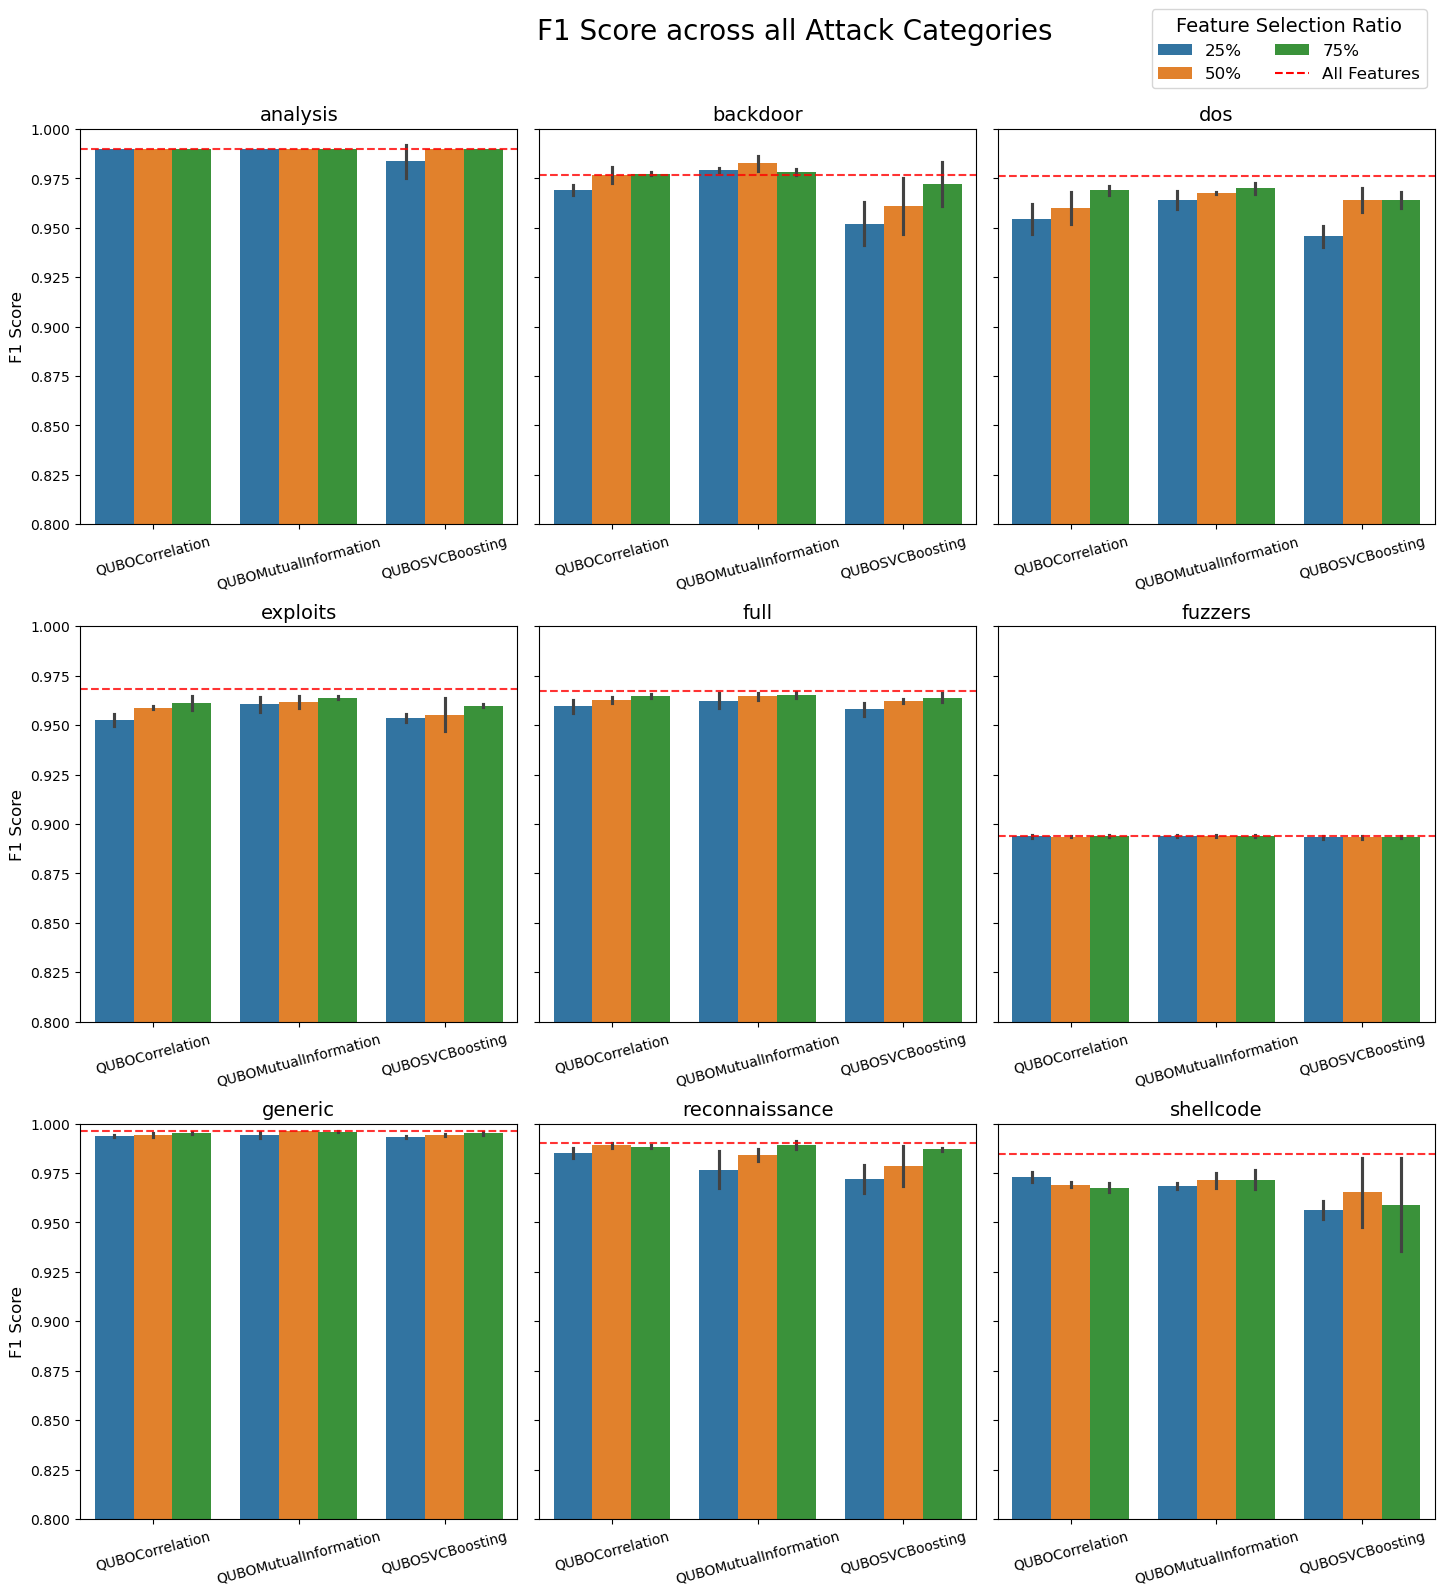

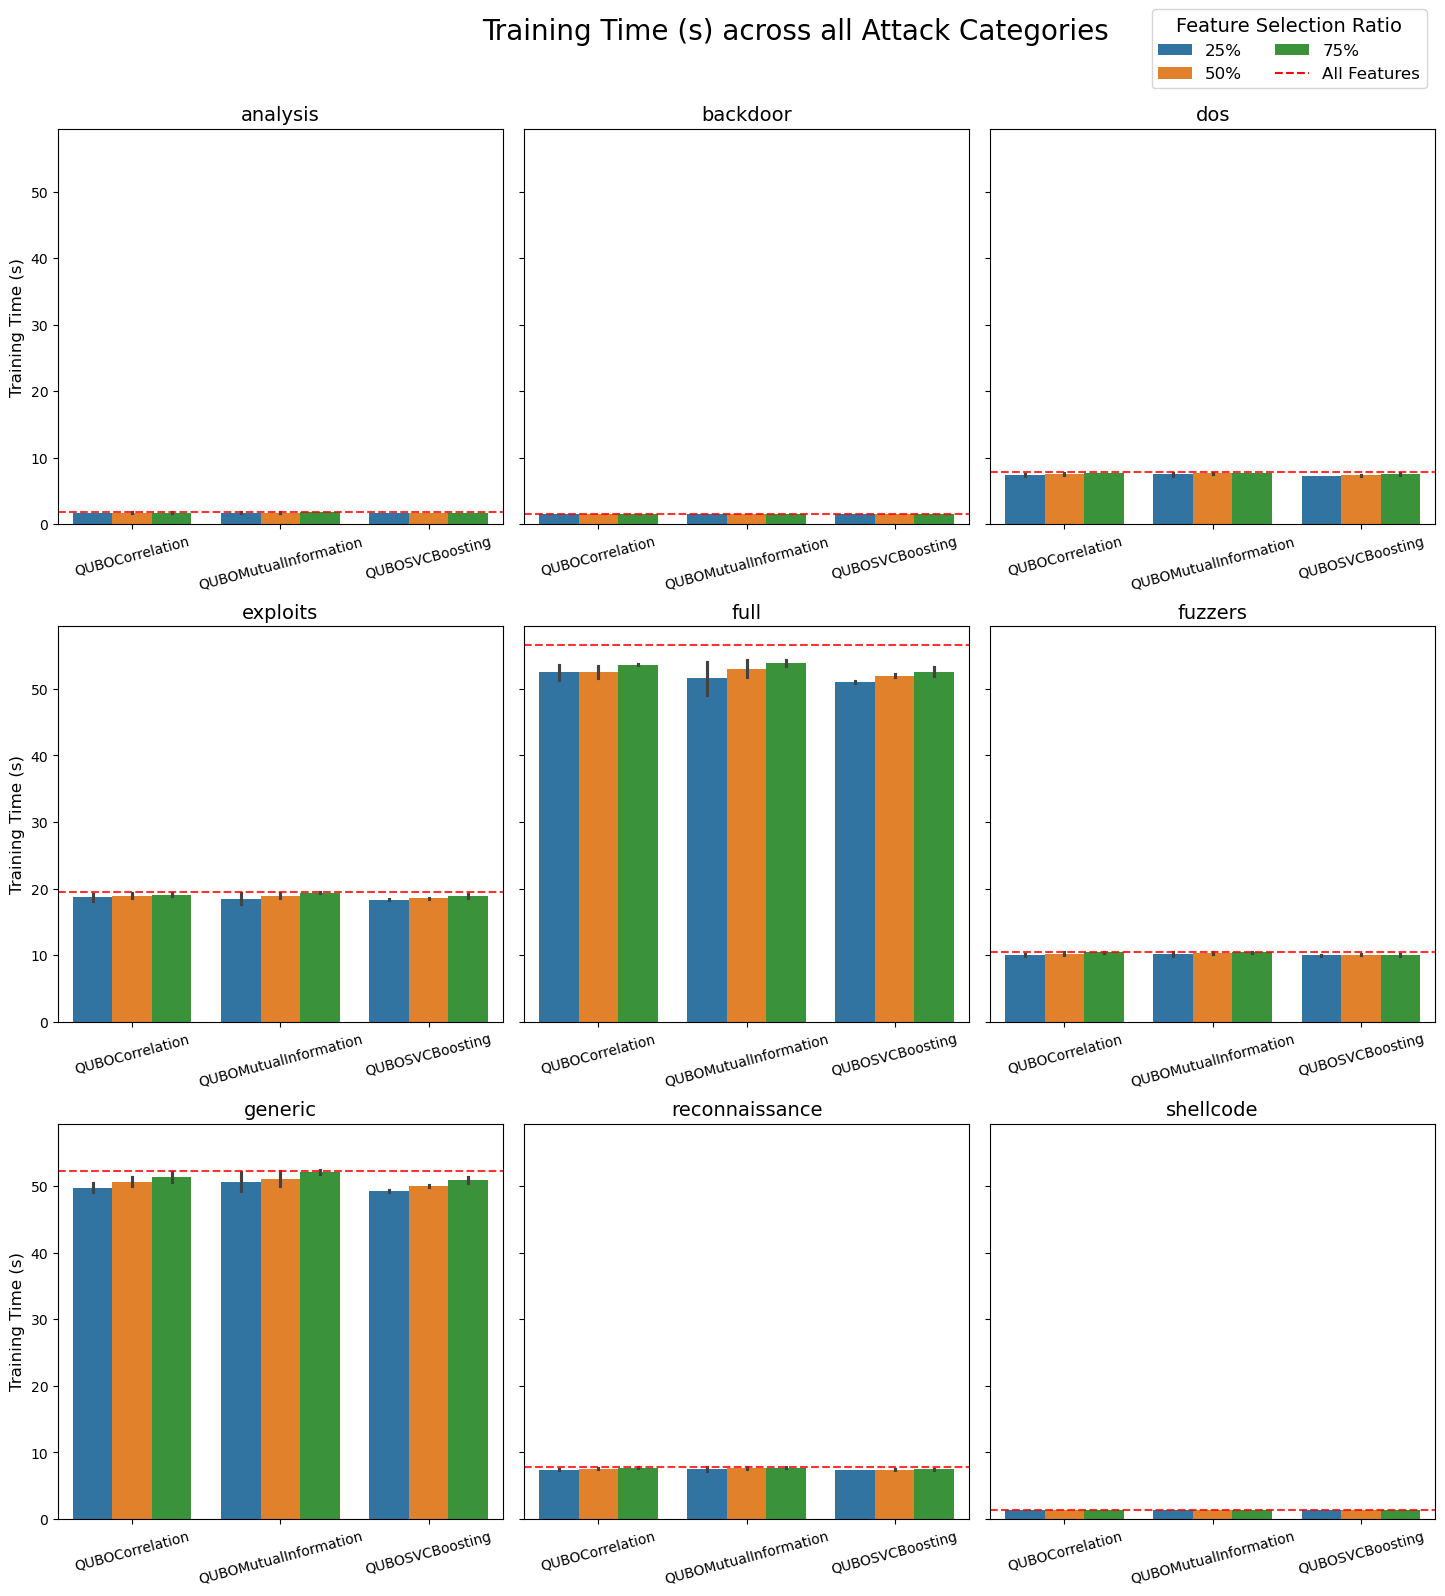

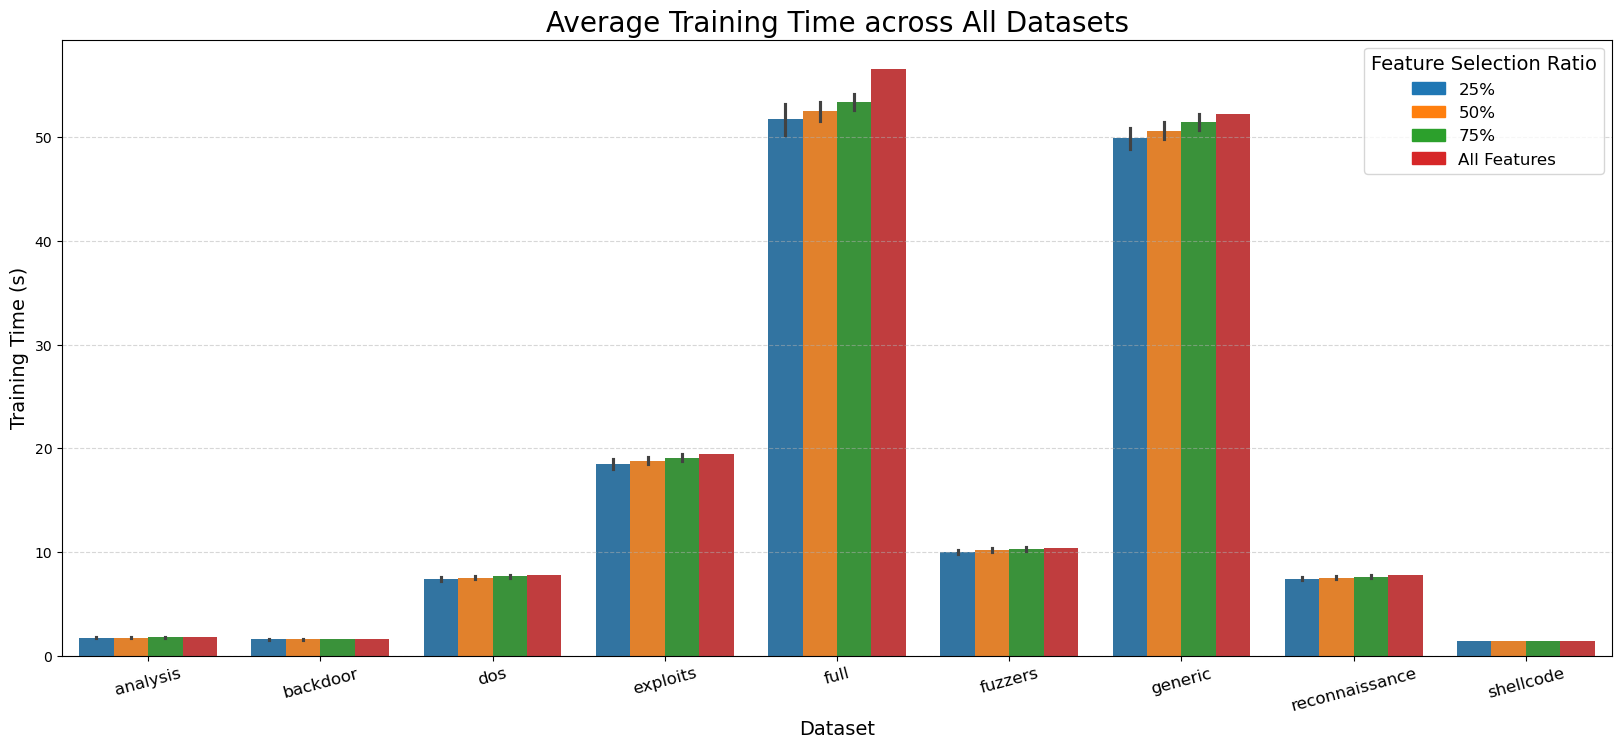

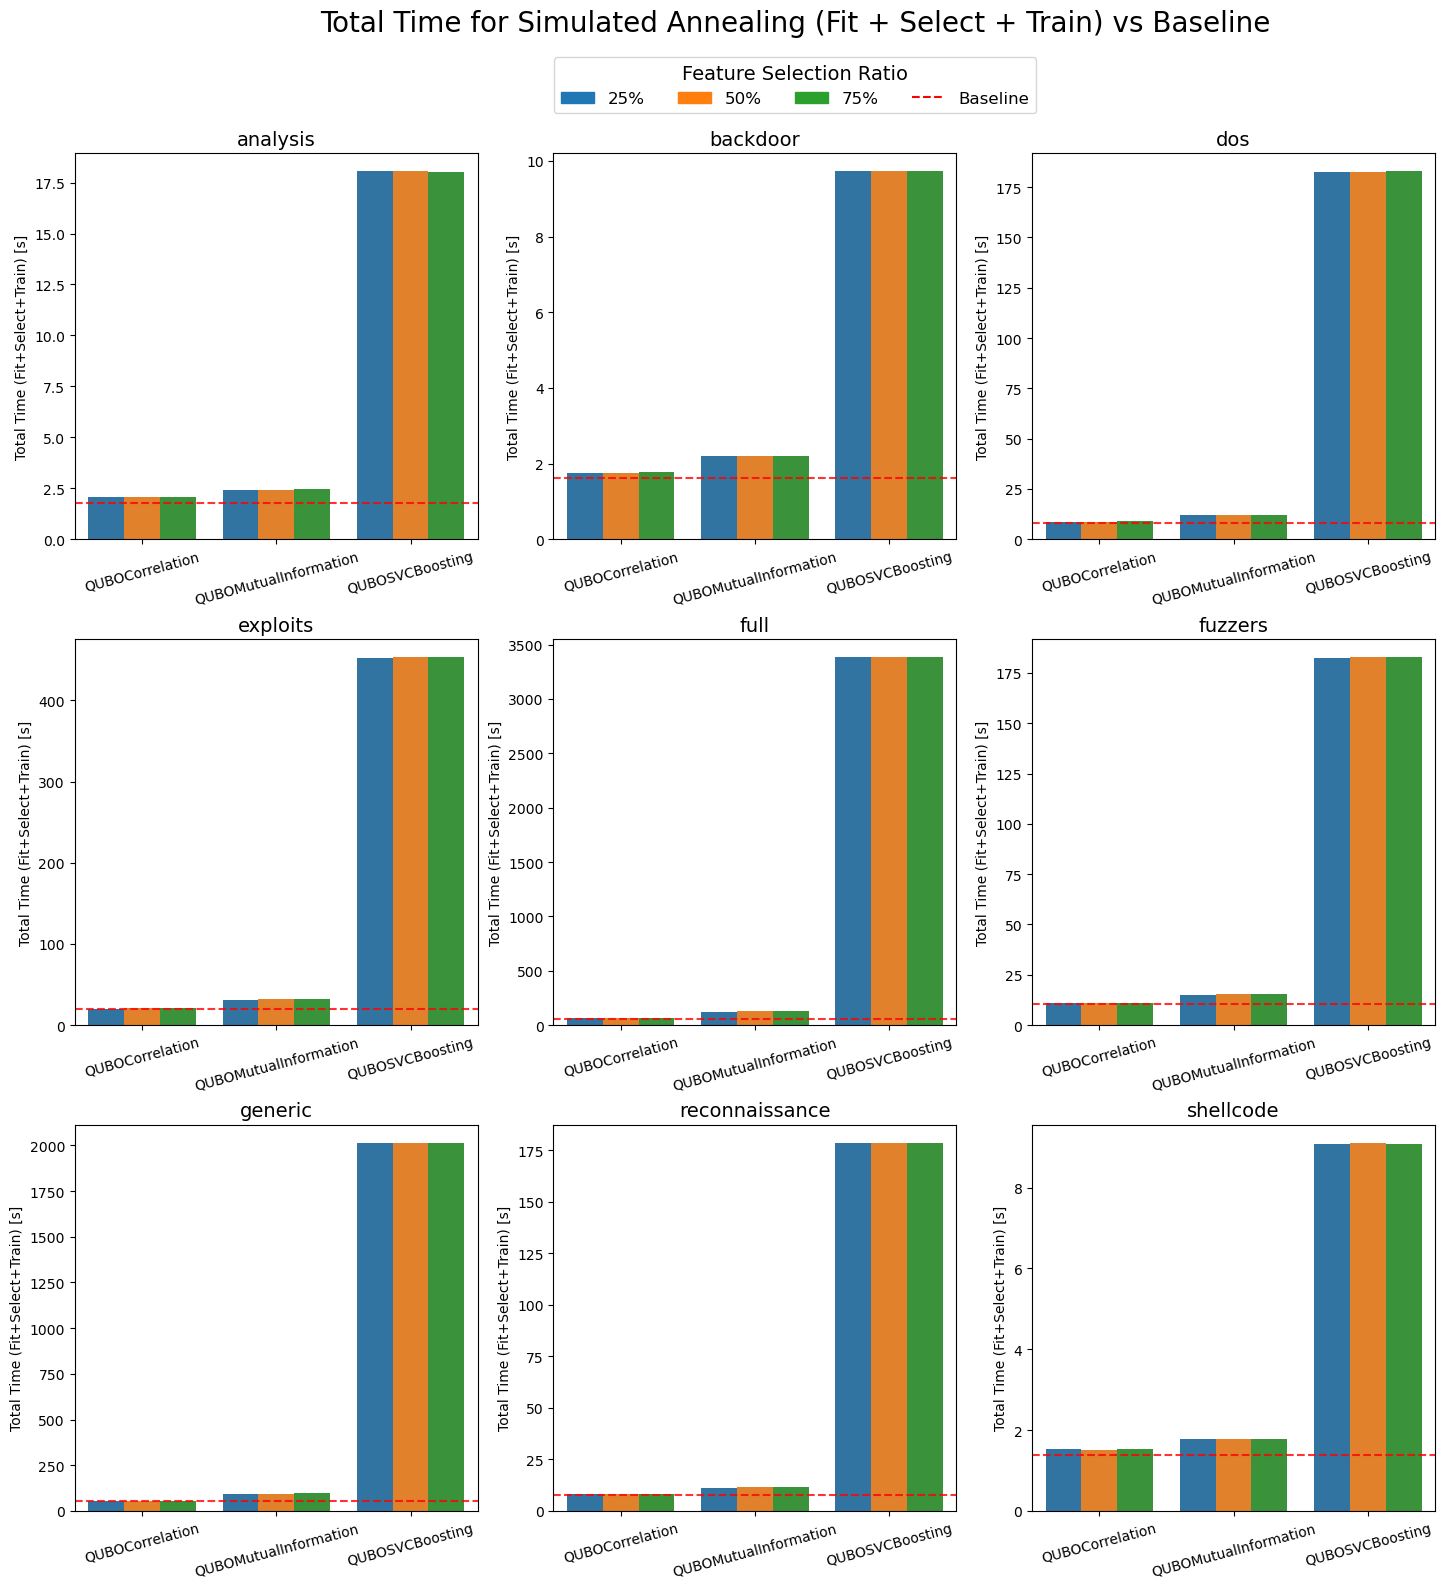

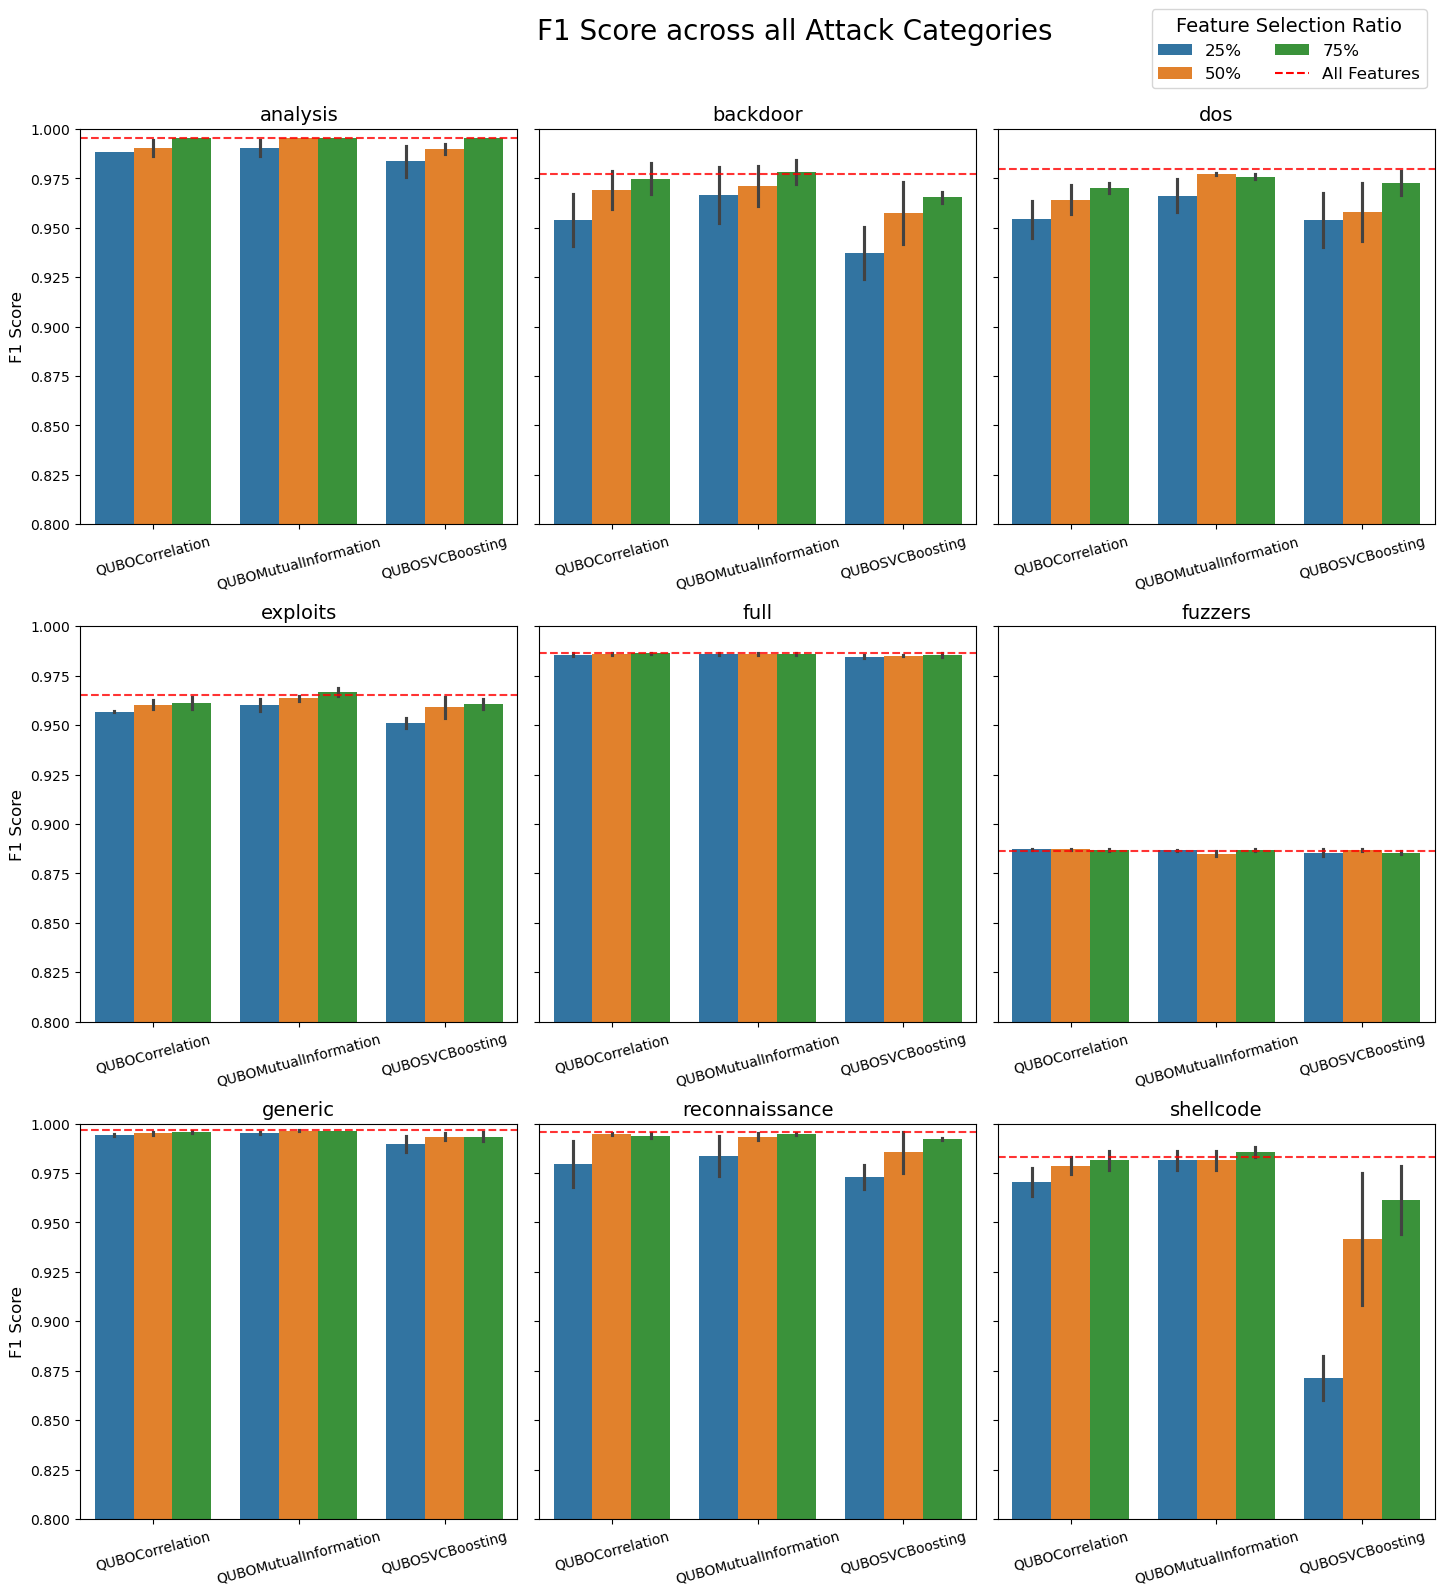

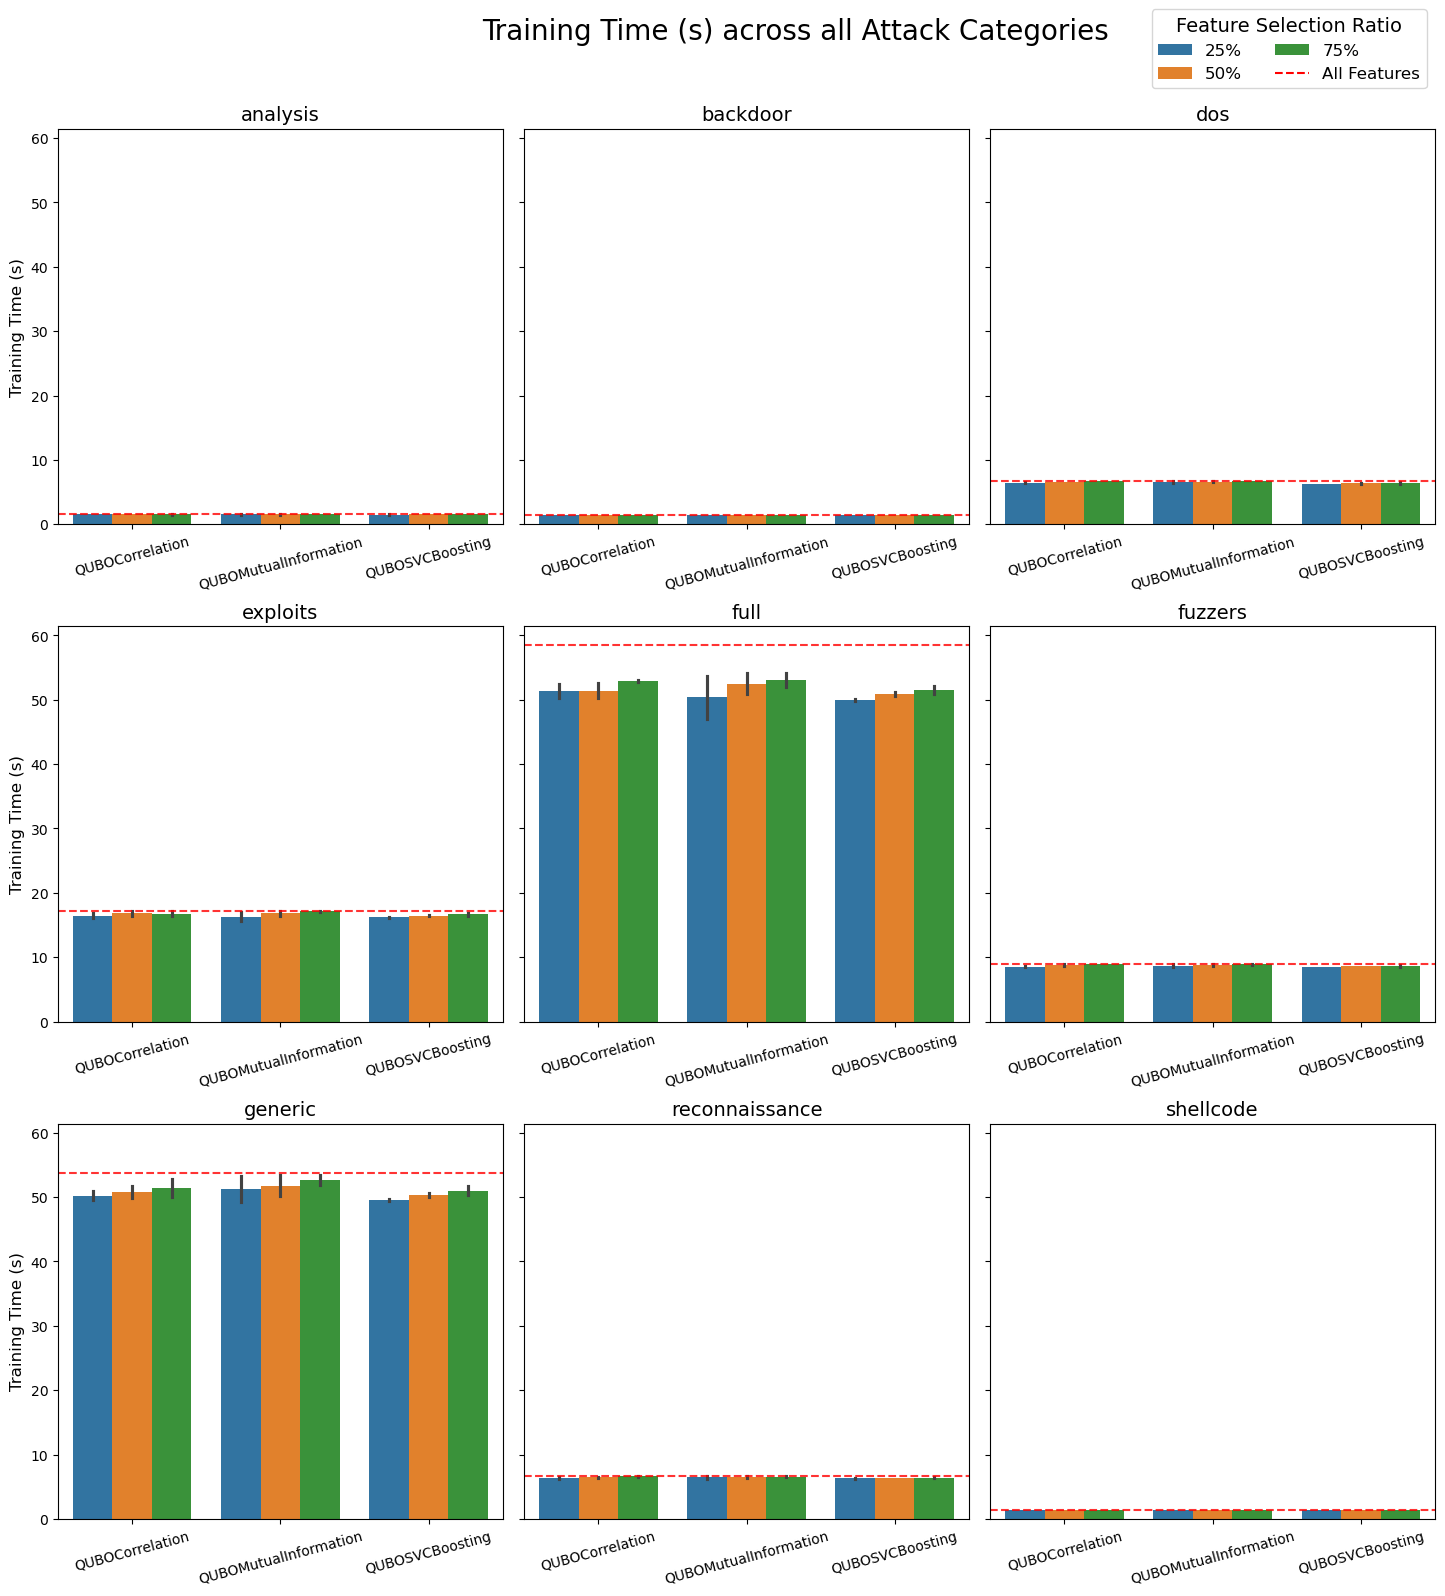

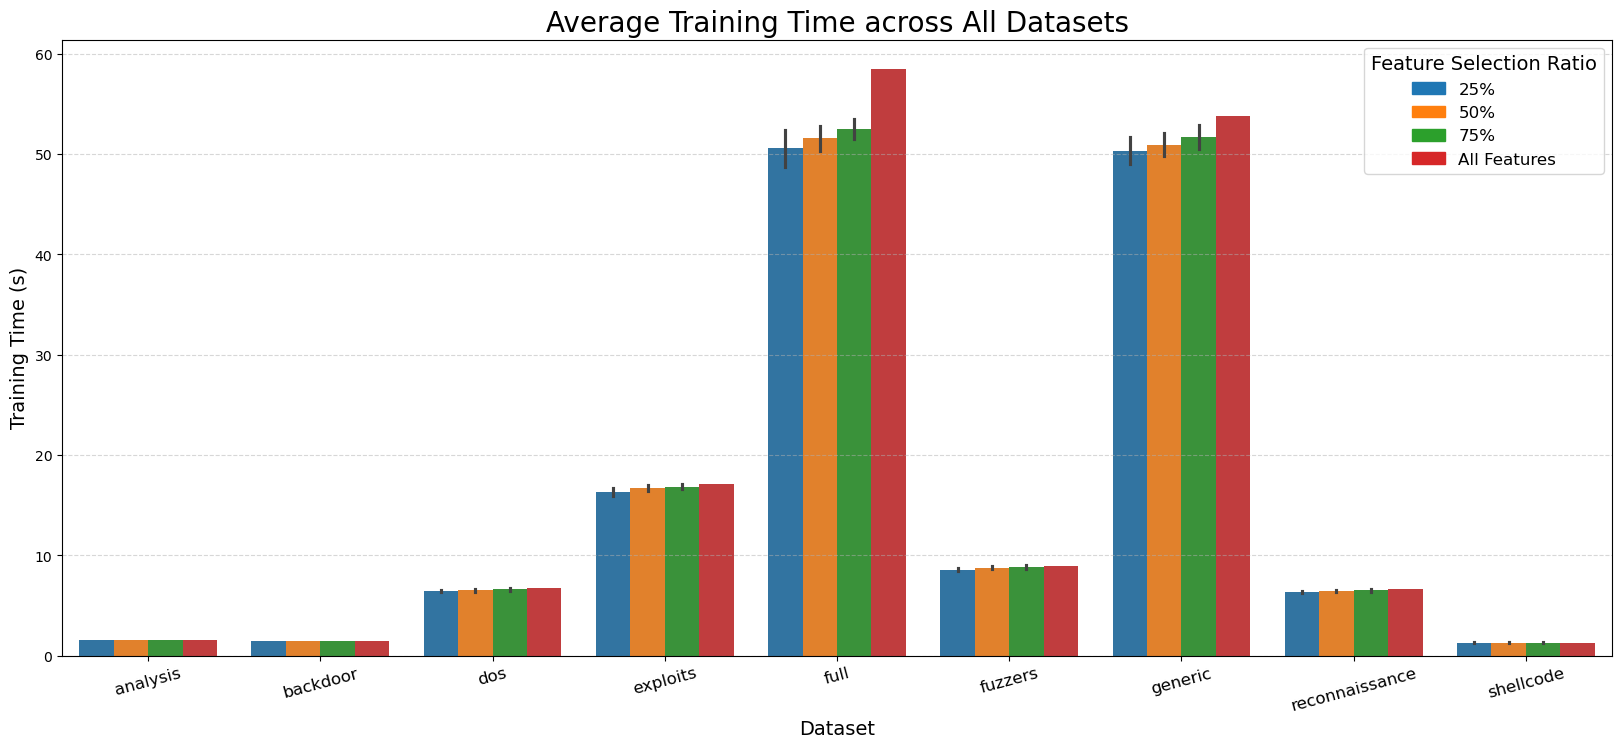

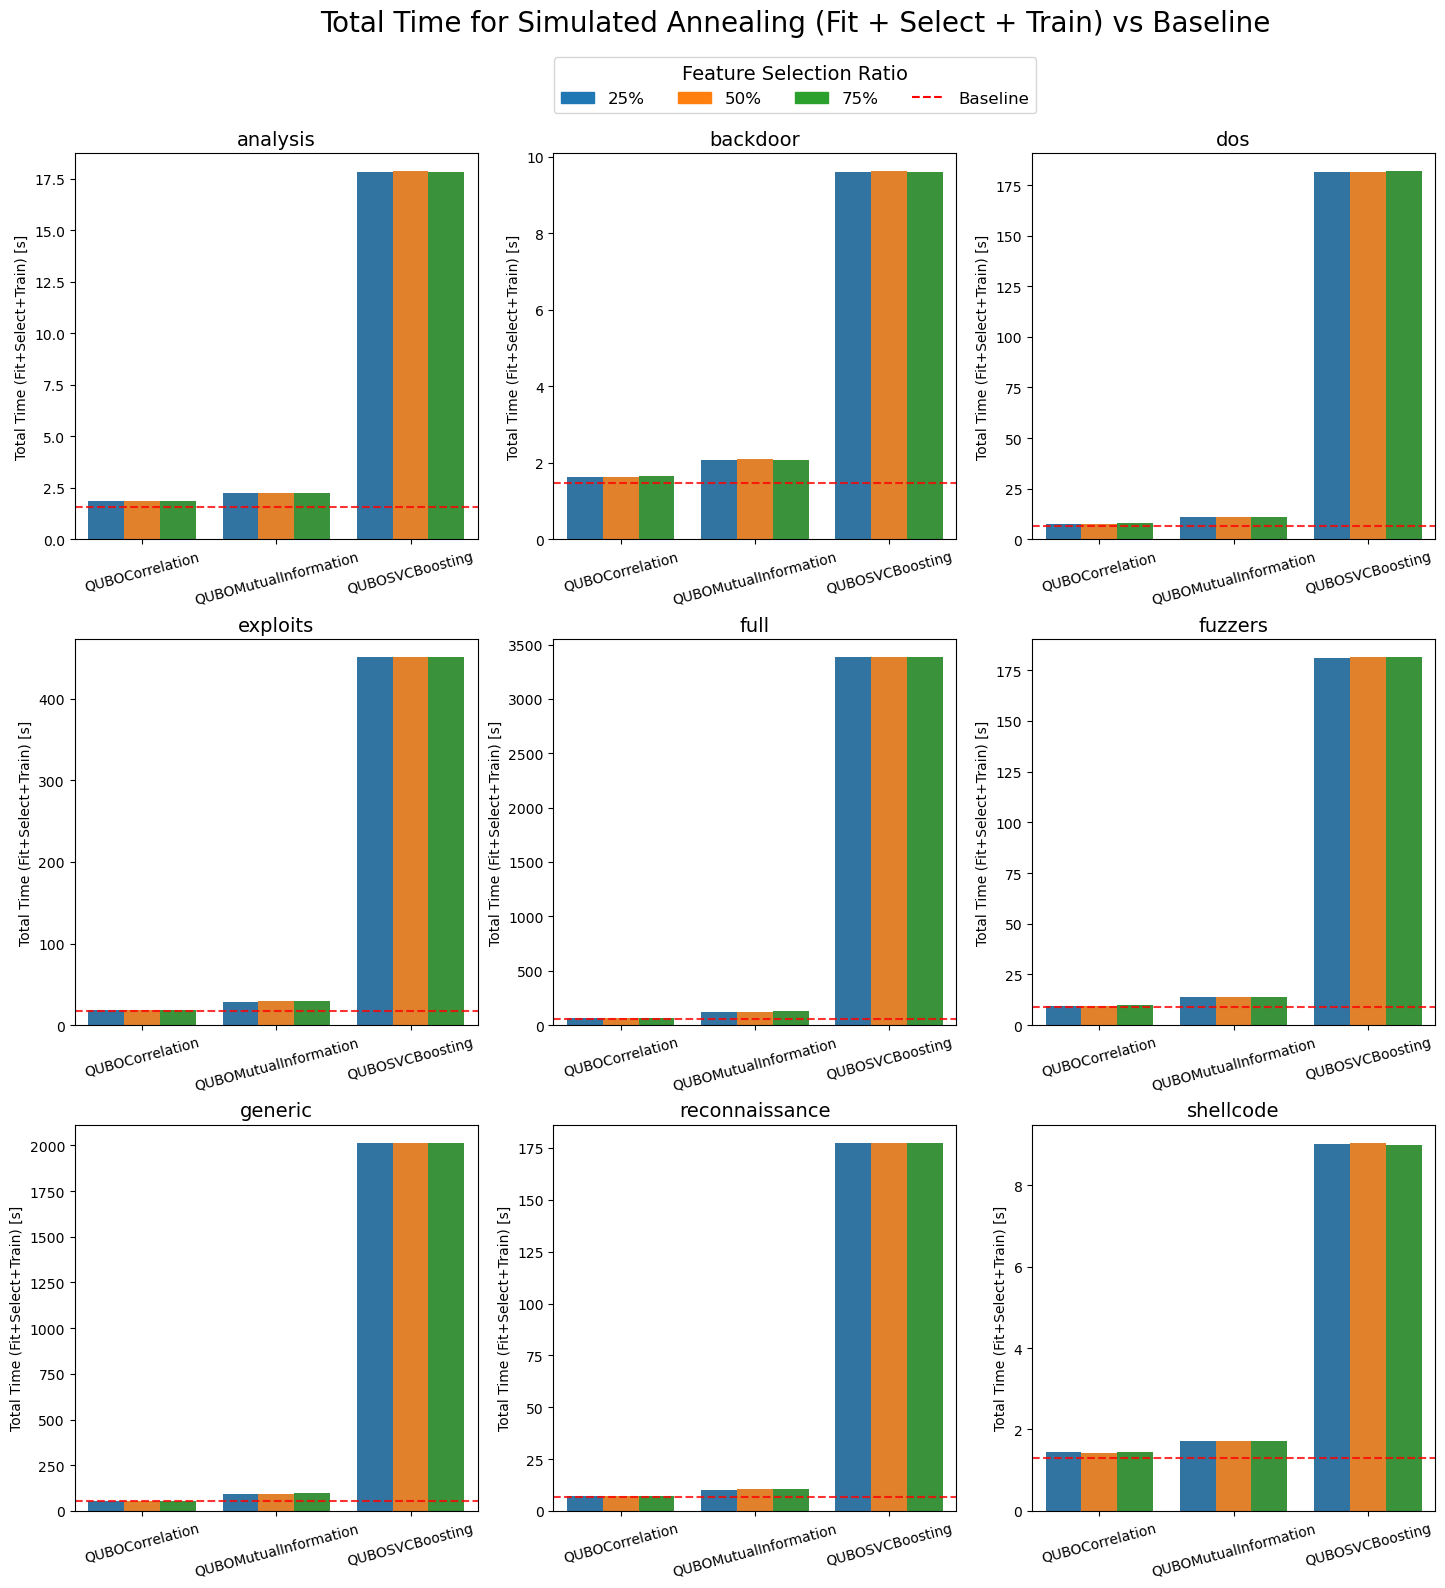

In [33]:
for model in MODELS:
    df = pd.read_csv(f"./results/{model}.csv")
    df_base = pd.read_csv(f"./results/all_{model}.csv")

    fig = plot_grid_updated(df, df_base, 'f1_malicious', y_min=0.8, y_max=1.0)
    fig.savefig(f"./results/figures/f1_{MODELS[model]}.png", dpi=300)

    fig = plot_grid_updated(df, df_base, 'train_time', y_min=None, y_max=None)
    fig.savefig(f"./results/figures/train_time_{MODELS[model]}.png", dpi=300)
    
    fig = plot_train_time_with_baseline_bar(df, df_base)
    fig.savefig(f"./results/figures/avg_train_time_{MODELS[model]}.png", dpi=300)
    
    qubo_solver = 'SimulatedAnnealing'
    fig = plot_total_time_grid(df, qfs_df, df_base, qubo_solver=qubo_solver)
    fig.savefig(f"./results/figures/total_time_{MODELS[model]}_{qubo_solver}.png", dpi=300)